In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IsotonicPEP import IsotonicPEP

In [14]:
def estimate_q(df, pep_col):
    df = df.copy()
    df.index += 1
    df[f"q_est_{pep_col}"] = df[pep_col].cumsum() / df.index
    return df

def cal_max_rel_diff(q_value, q_est):
    relative_difference = np.abs(q_est - q_value) / np.where(q_value != 0, q_value, np.nan)
    return np.nanmax(relative_difference) * 100

pep_processor = IsotonicPEP()
c1, c2= "block merge", "hard clip"
s1, s2 = "real", "logit"
p1, p2 = "basic PAVA", "interpolated PAVA"
m1 = ("real_basic_bm", c1, s1, p1)
m2 = ("real_interp_bm", c1, s1, p2)
m3 = ("logit_basic_bm", c1, s2, p1)
m4 = ("logit_interp_bm", c1, s2, p2)
m5 = ("real_basic_clip", c2, s1, p1)
m6 = ("real_interp_clip", c2, s1, p2)
m7 = ("logit_basic_clip", c2, s2, p1)
m8 = ("logit_interp_clip", c2, s2, p2)

In [15]:
center_methods = ["mean", "midpoint"]
methods = [m1, m2, m3, m4, m5, m6, m7, m8]
input_file = f"data/iso0.peptide.target.txt"
for center_method in center_methods:
    df = pd.read_csv(input_file, sep="\t")
    q_values = df["q-value"].values
    for col_name, raw_method, space, pava_method in methods:
        df[col_name] = pep_processor.pep_regression(q_values, raw_method, space, pava_method, center_method="mean")
        df = estimate_q(df, col_name)
    columns_to_drop = ["PSMId", "filename", "score", "peptide", "proteinIds"]
    df = df.drop(columns=columns_to_drop)
    output_file = f"data/{center_method}.iso0.q_pep.txt"
    df.to_csv(output_file, sep="\t", index=False)

    print("Results saved to:", output_file)
    print(f"Max relative difference ({center_method}):")
    for col_name, _, _, _ in methods:
        max_diff = cal_max_rel_diff(df["q-value"].values, df[f"q_est_{col_name}"].values)
        print(f"{col_name}: {max_diff:.0f}%")

Results saved to: data/mean.iso0.q_pep.txt
Max relative difference (mean):
real_basic_bm: 59%
real_interp_bm: 59%
logit_basic_bm: 92%
logit_interp_bm: 92%
real_basic_clip: 80%
real_interp_clip: 83%
logit_basic_clip: 92%
logit_interp_clip: 92%
Results saved to: data/midpoint.iso0.q_pep.txt
Max relative difference (midpoint):
real_basic_bm: 59%
real_interp_bm: 59%
logit_basic_bm: 92%
logit_interp_bm: 92%
real_basic_clip: 80%
real_interp_clip: 83%
logit_basic_clip: 92%
logit_interp_clip: 92%


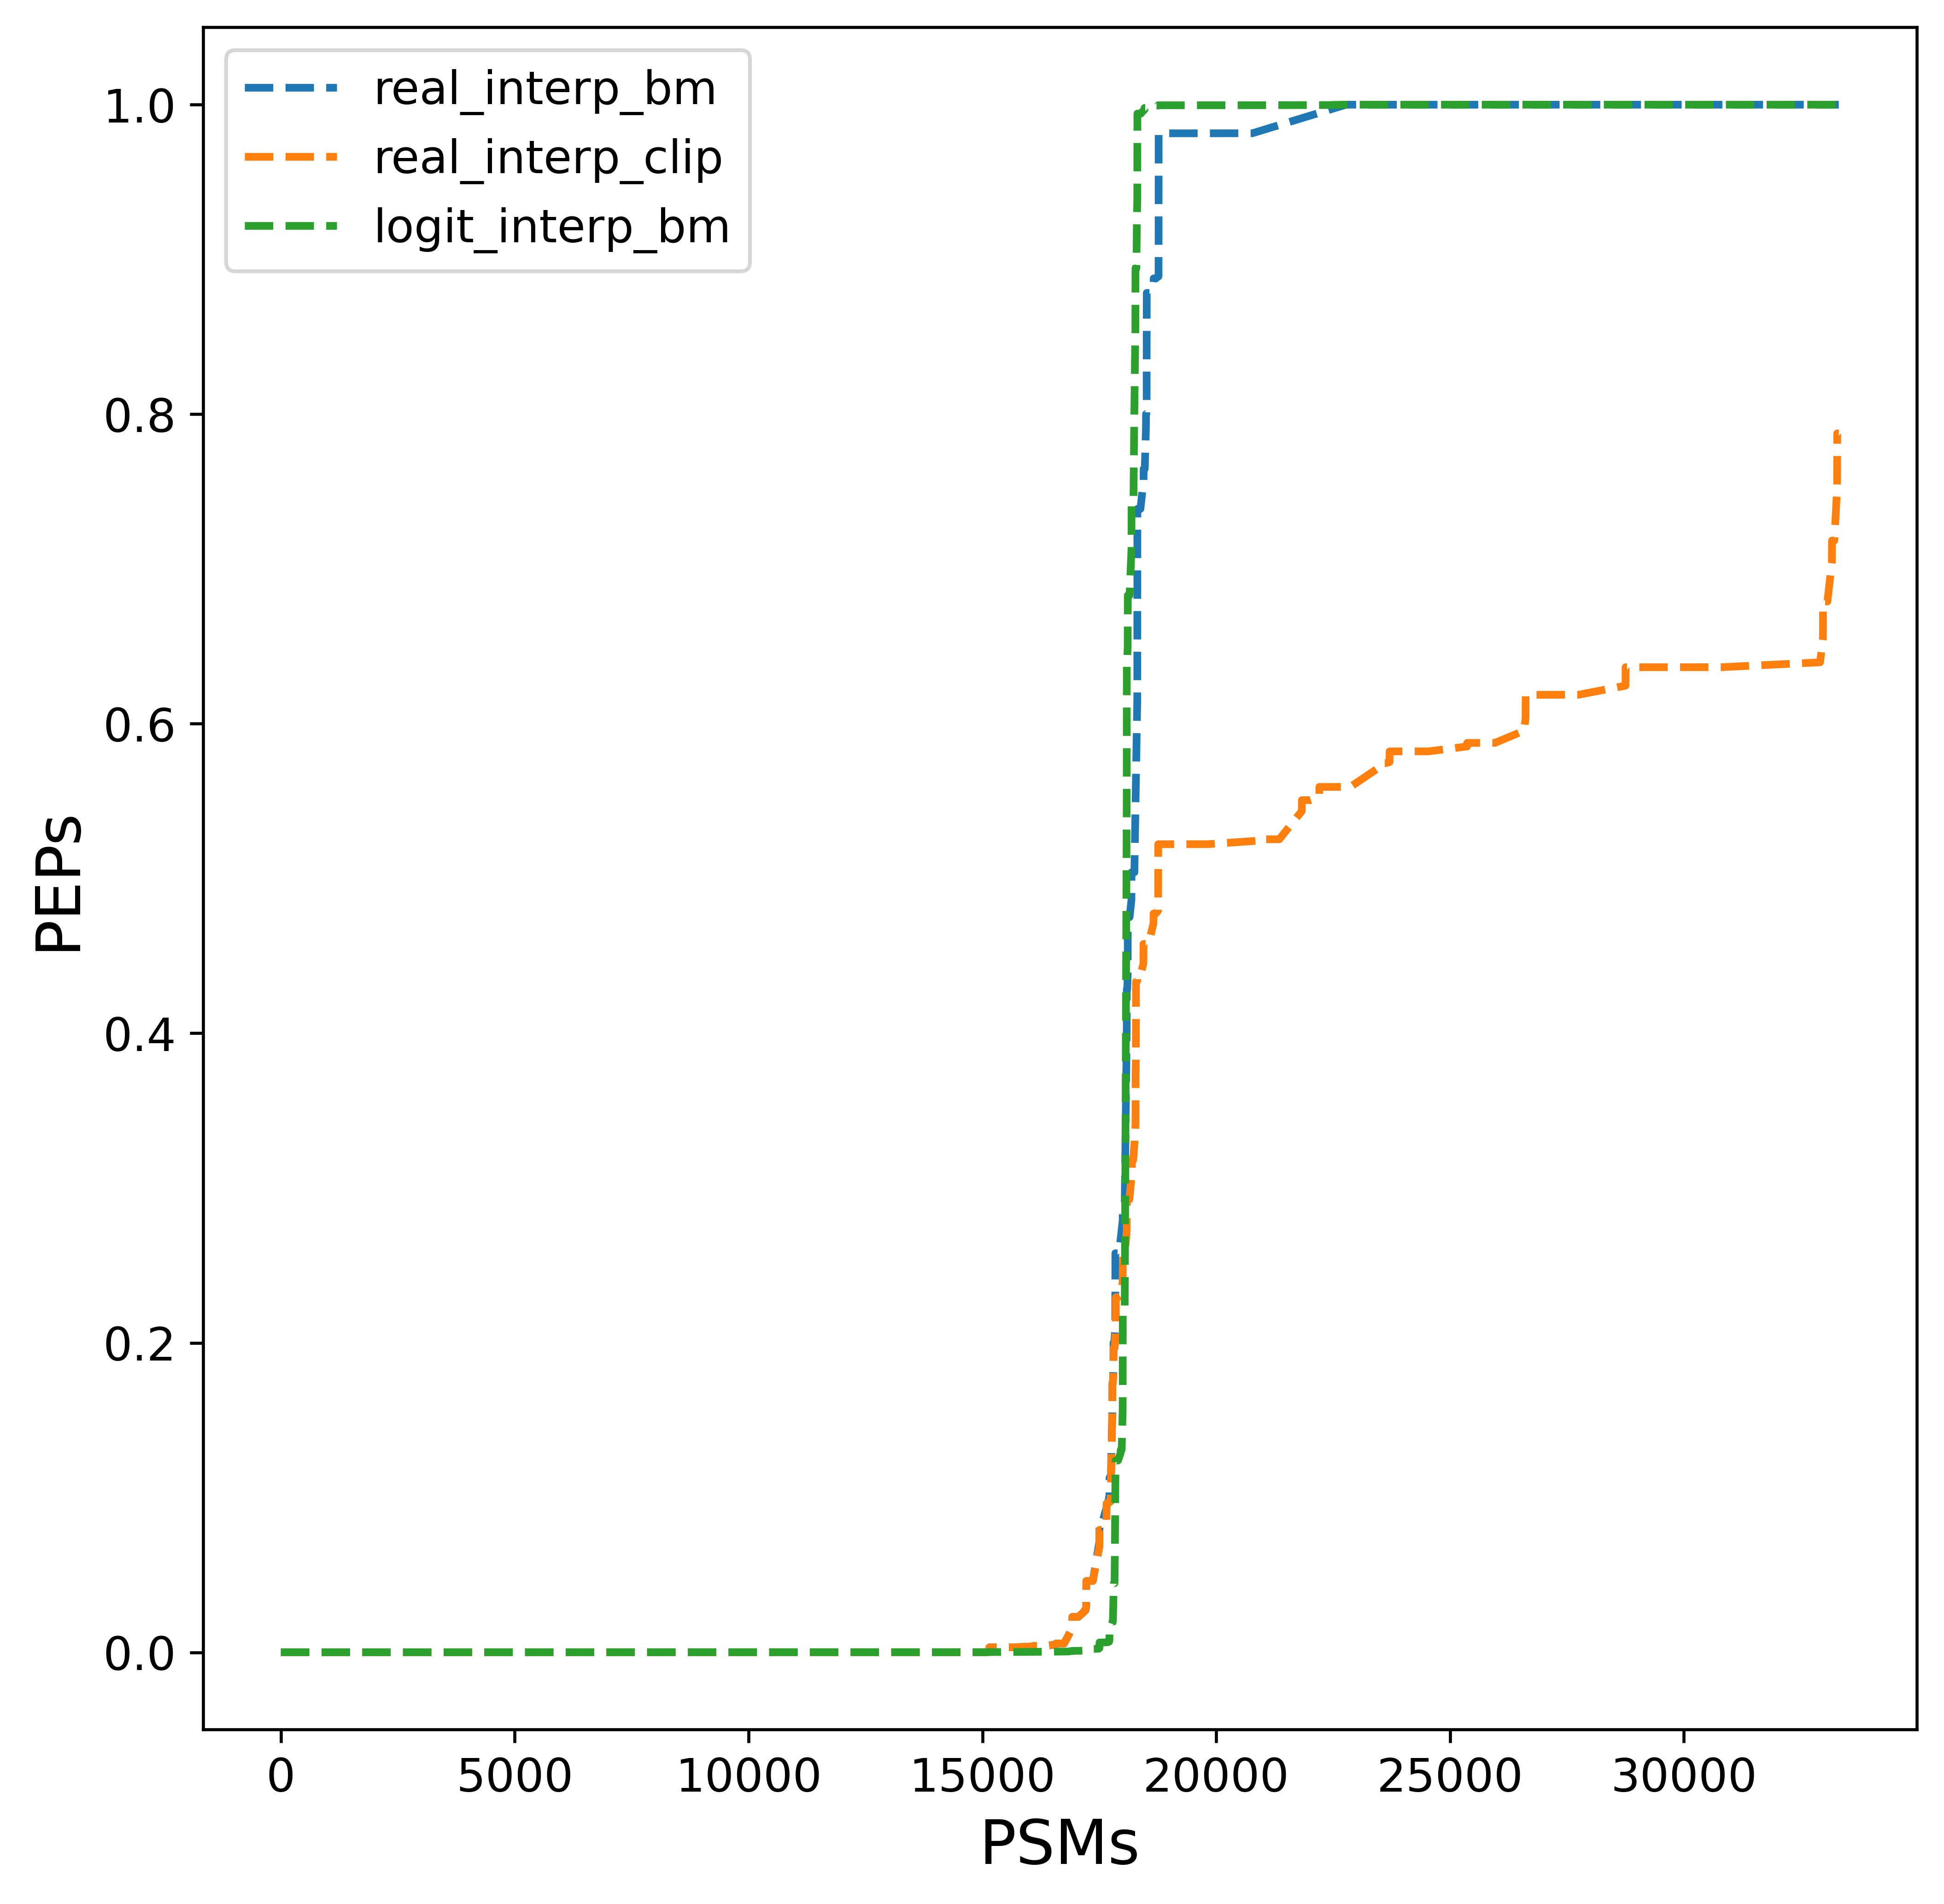

In [26]:
df = pd.read_csv(f"data/mean.iso0.q_pep.txt", sep="\t")
plt.figure(figsize=(8, 8), dpi=600)
q_values = df["q-value"]
x_axis = np.arange(1, len(q_values) + 1)
plt.plot(x_axis, df["real_interp_bm"], label="real_interp_bm", linewidth=2, linestyle="--")
plt.plot(x_axis, df["real_interp_clip"], label="real_interp_clip", linewidth=2, linestyle="--")
plt.plot(x_axis, df["logit_interp_bm"], label="logit_interp_bm", linewidth=2, linestyle="--")

plt.xlabel("PSMs", fontsize=16)
plt.ylabel("PEPs", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.ylim(0, 1.2)
plt.legend(loc="upper left", fontsize=12)
plt.show()

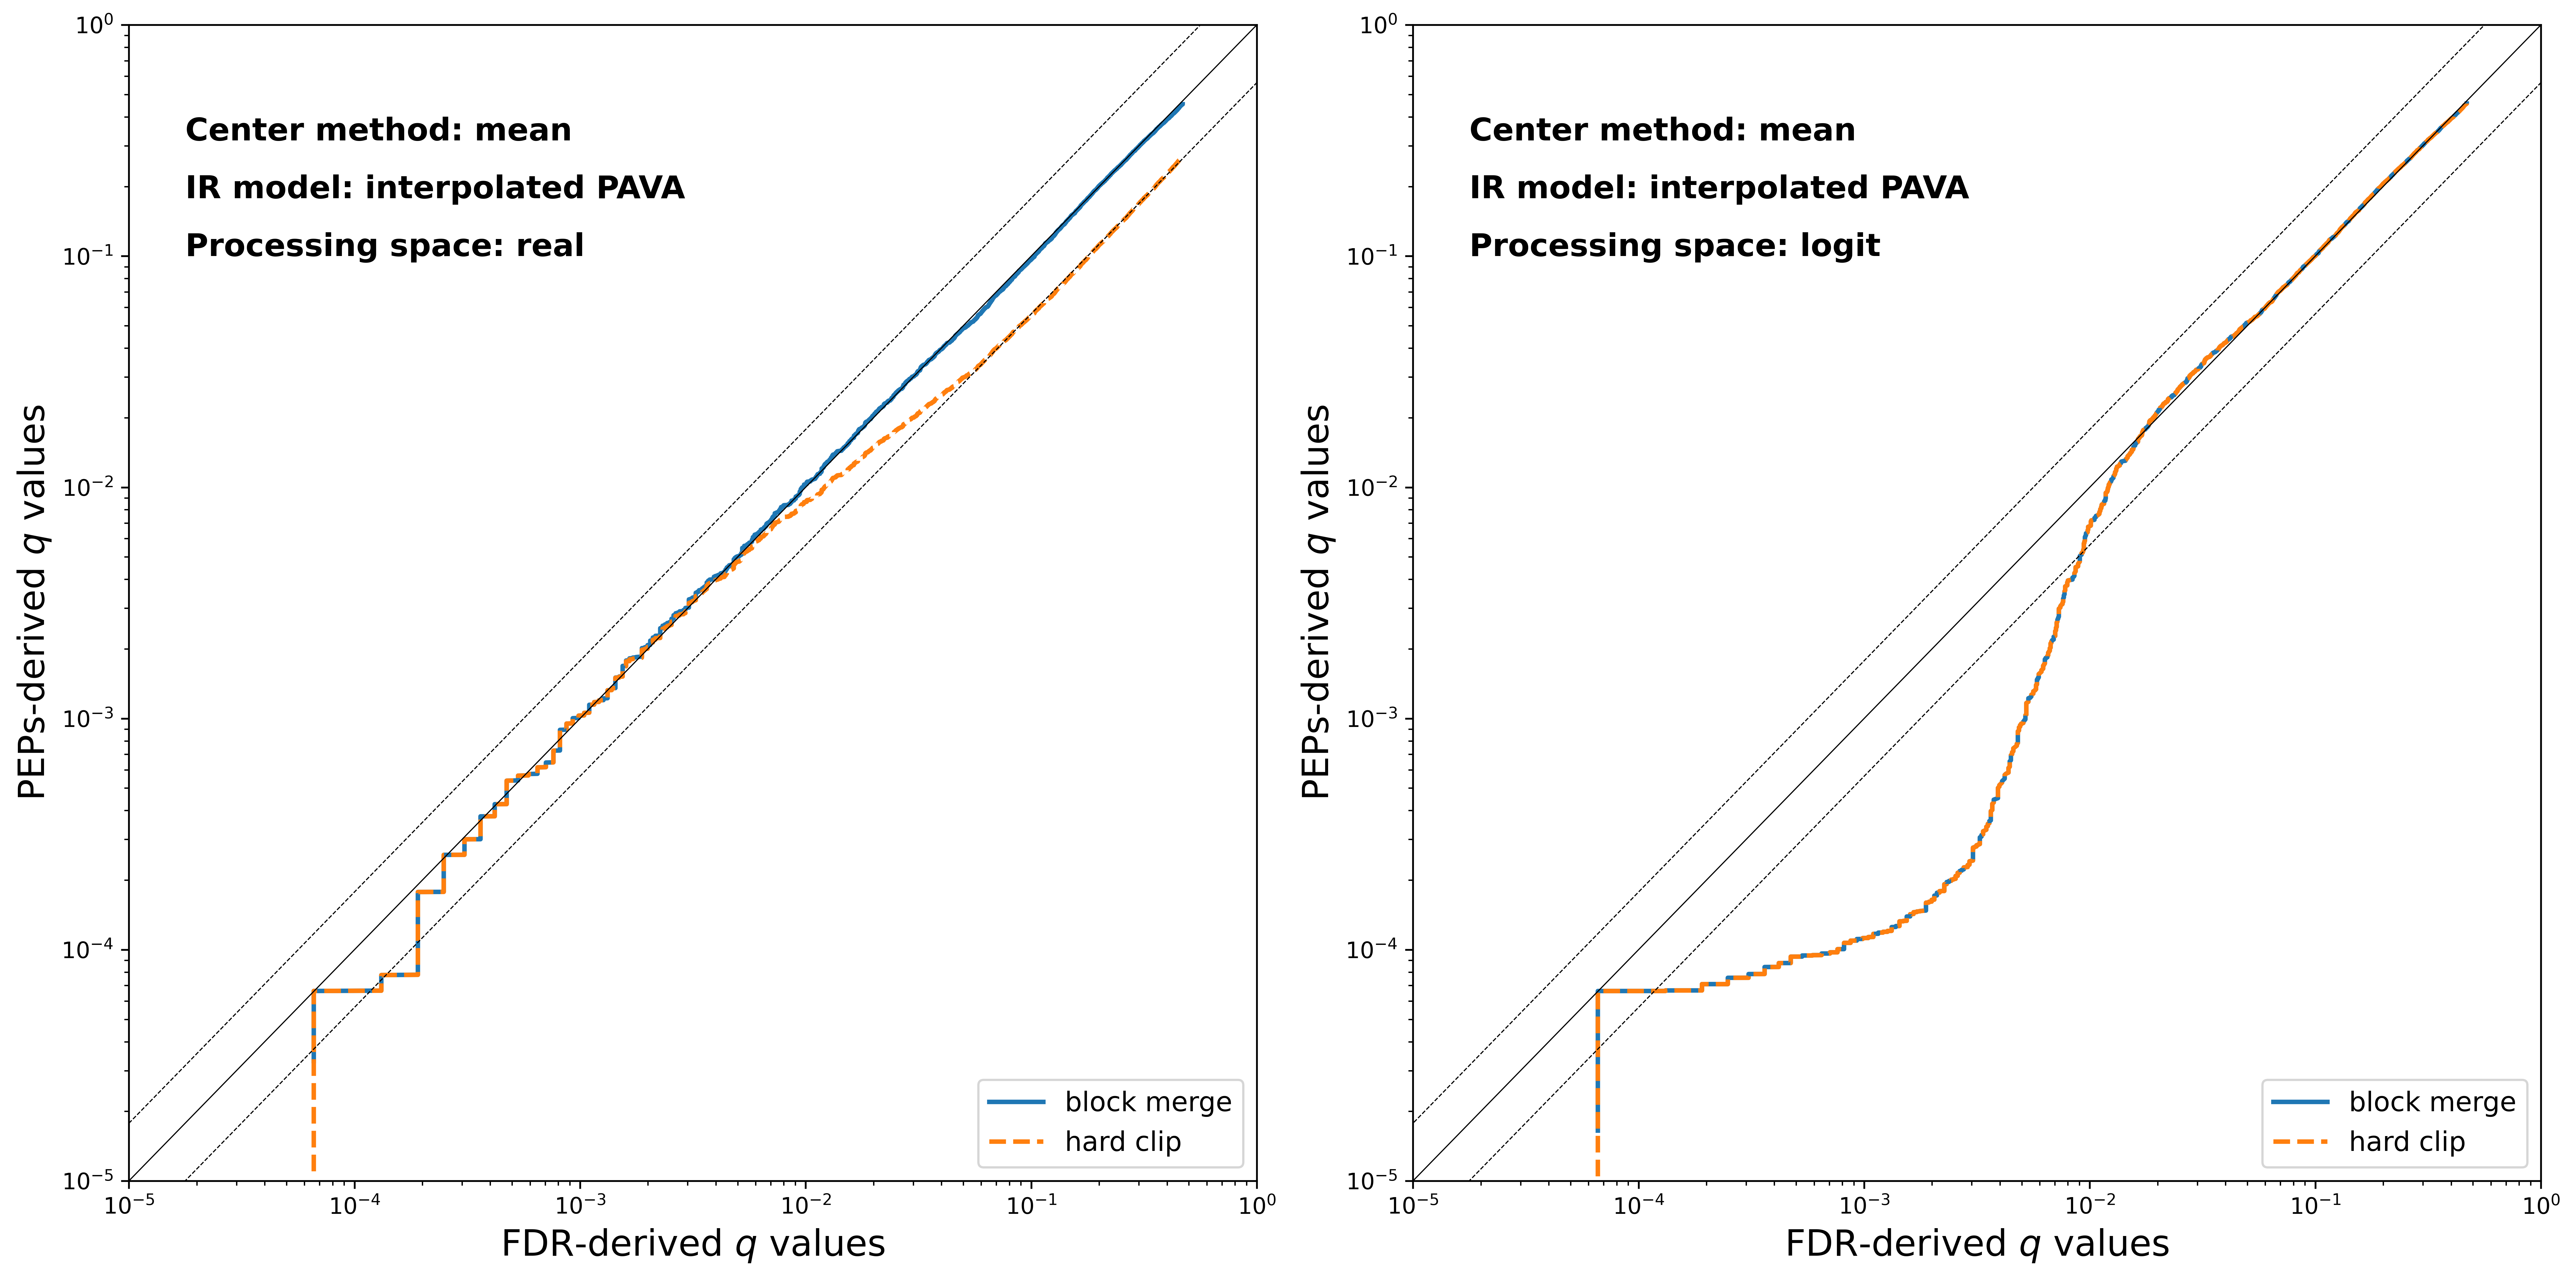

In [ ]:
center_method = "mean"
df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=600)
linestyle_map = {"block merge": "-", "hard clip": "--"}
ax = axes[0]
ax.text(0.05, 0.9, f"Center method: {center_method}", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "IR model: interpolated PAVA", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: real", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
methods_real = [m2, m6]
for col_name, clipping, _, _ in methods_real:
    linestyle = linestyle_map[clipping]
    ax.plot(df["q-value"], df[f"q_est_{col_name}"],
            label=clipping, linestyle=linestyle, linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
ax.legend(loc='lower right', fontsize=12)
ax = axes[1]
ax.text(0.05, 0.9, f"Center method: {center_method}", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "IR model: interpolated PAVA", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: logit", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
methods_logit = [m4, m8]
for col_name, clipping, _, _ in methods_logit:
    linestyle = linestyle_map[clipping]
    ax.plot(df["q-value"], df[f"q_est_{col_name}"],
            label=clipping, linestyle=linestyle, linewidth=2)
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
ax.legend(loc='lower right', fontsize=12)
plt.tight_layout()
plt.savefig(f"figs/block_vs_clip.mean_interp.png",bbox_inches="tight")
plt.show()

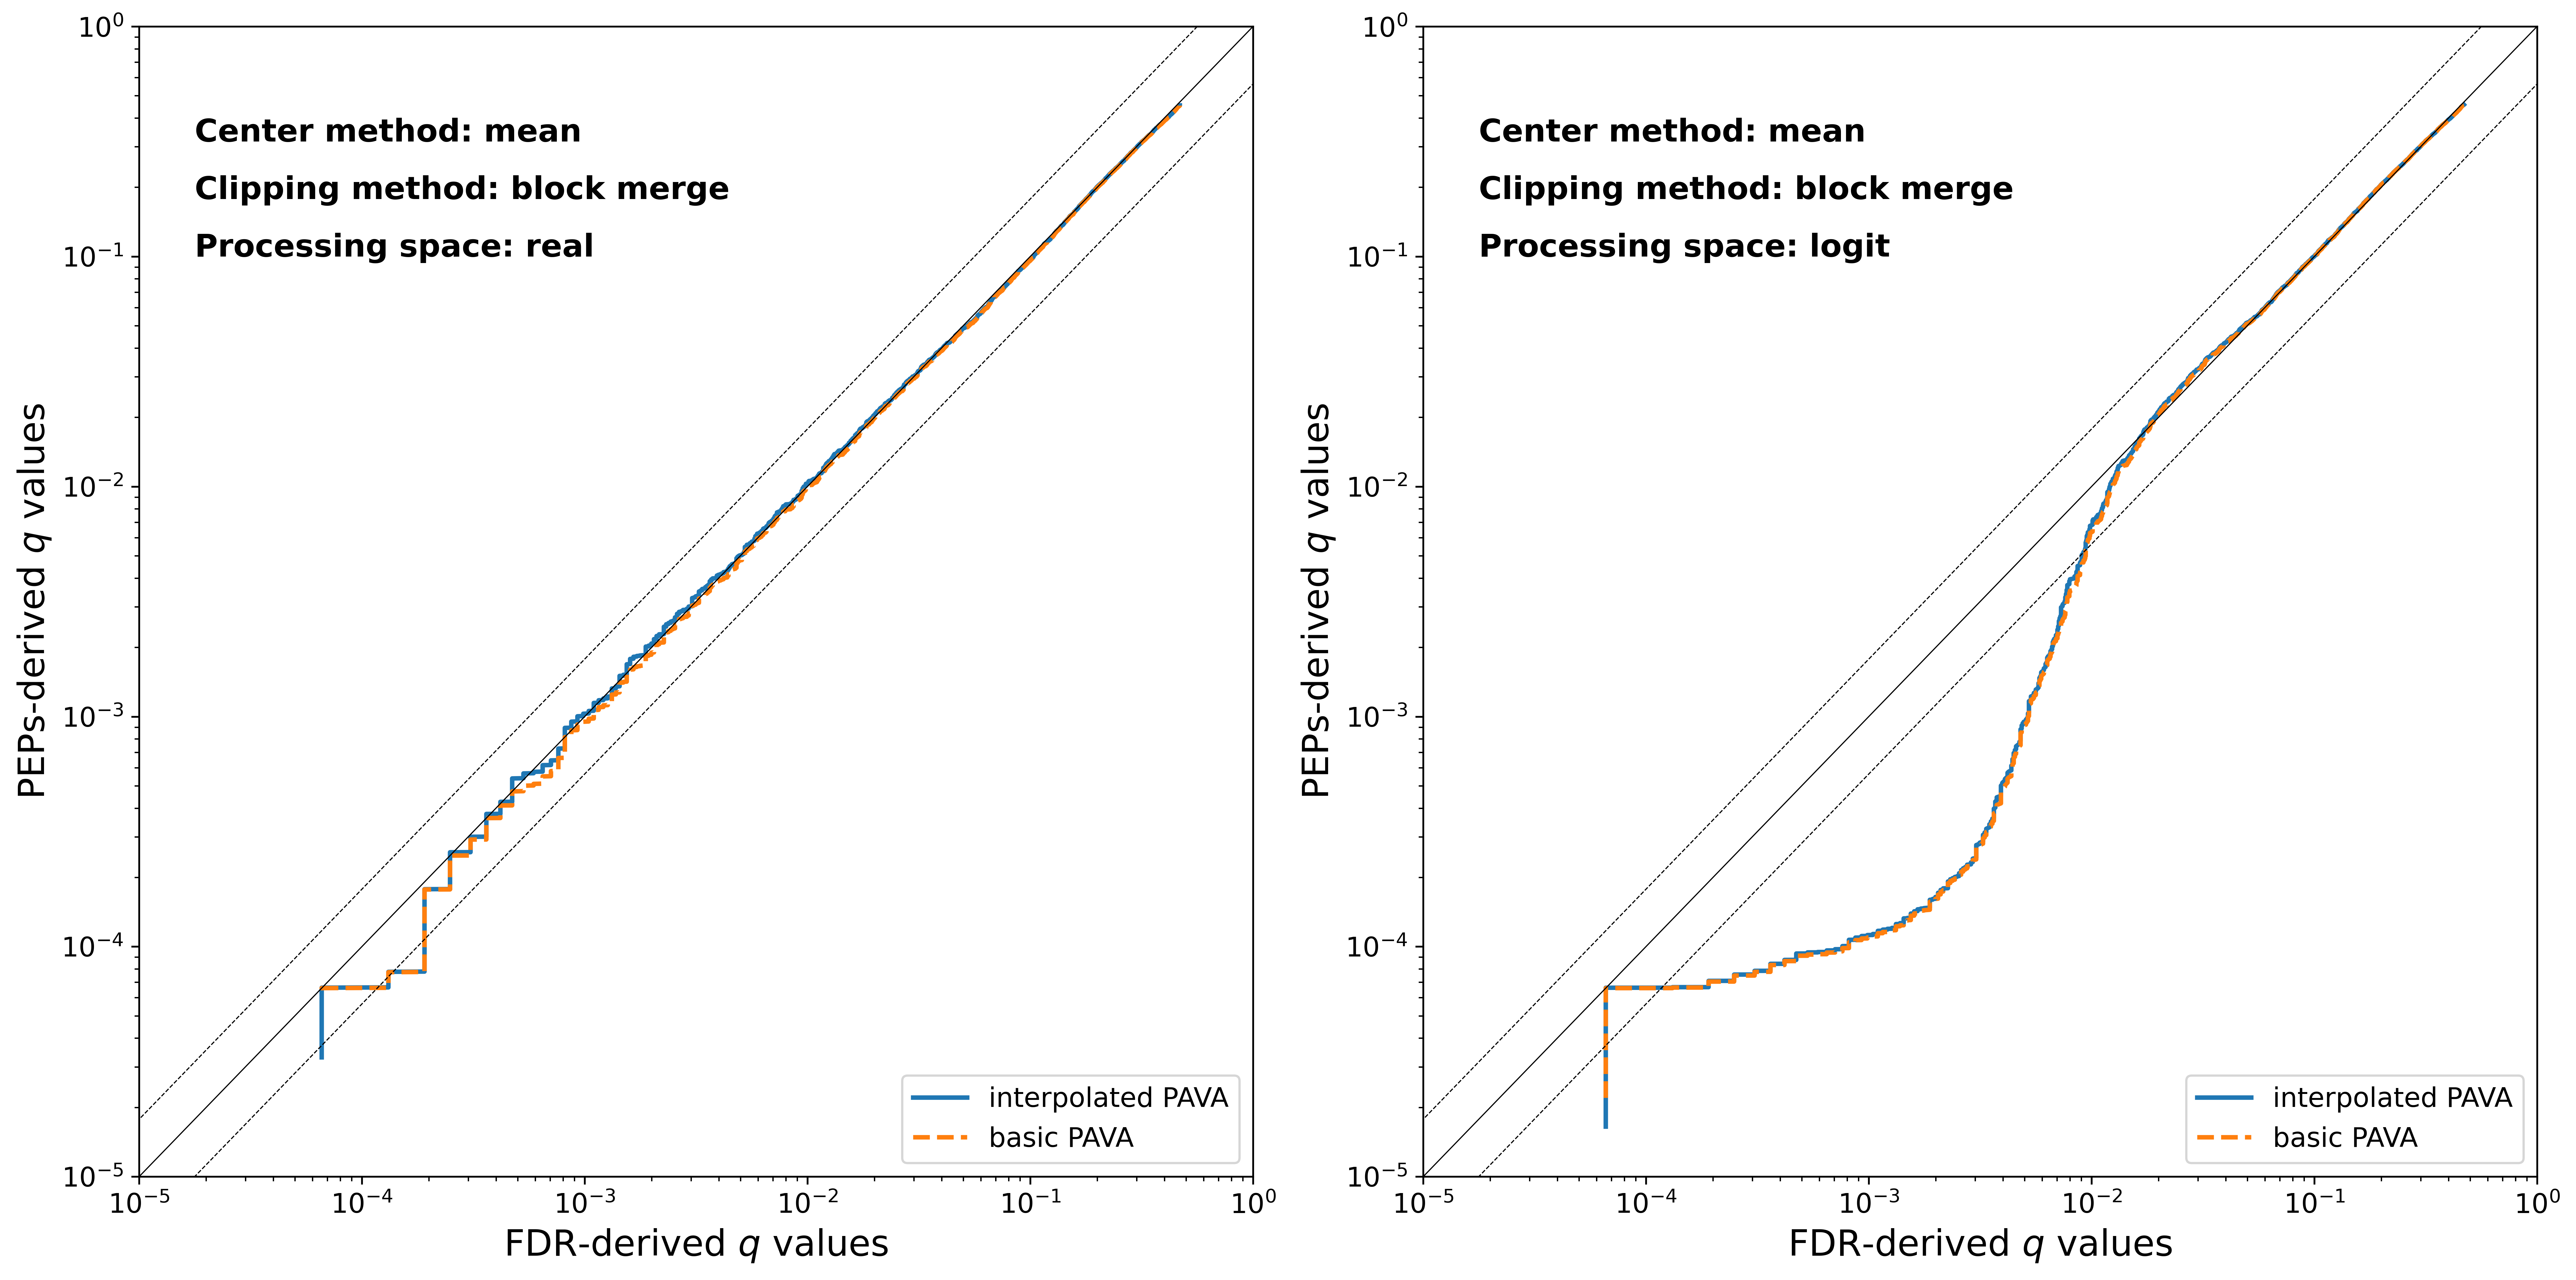

In [20]:
center_method = "mean"
df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=600)
linestyle_map = {"interpolated PAVA": "-", "basic PAVA": "--"}
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
ax = axes[0]
ax.text(0.05, 0.9, f"Center method: {center_method}", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "Clipping method: block merge", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: real", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
methods_real = [m2, m1]
for col_name, _, _, pava in methods_real:
    linestyle = linestyle_map[pava]
    ax.plot(df["q-value"], df[f"q_est_{col_name}"],
            label=pava, linestyle=linestyle, linewidth=2)
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
ax = axes[1]
ax.text(0.05, 0.9, f"Center method: {center_method}", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "Clipping method: block merge", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: logit", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
methods_logit = [m4, m3]
for col_name, _, _, pava in methods_logit:
    linestyle = linestyle_map[pava]
    ax.plot(df["q-value"], df[f"q_est_{col_name}"],
            label=pava, linestyle=linestyle, linewidth=2)
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.legend(loc='lower right', fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
plt.tight_layout()
plt.savefig("figs/interp_vs_basic.mean_bm.png", bbox_inches="tight")
plt.show()

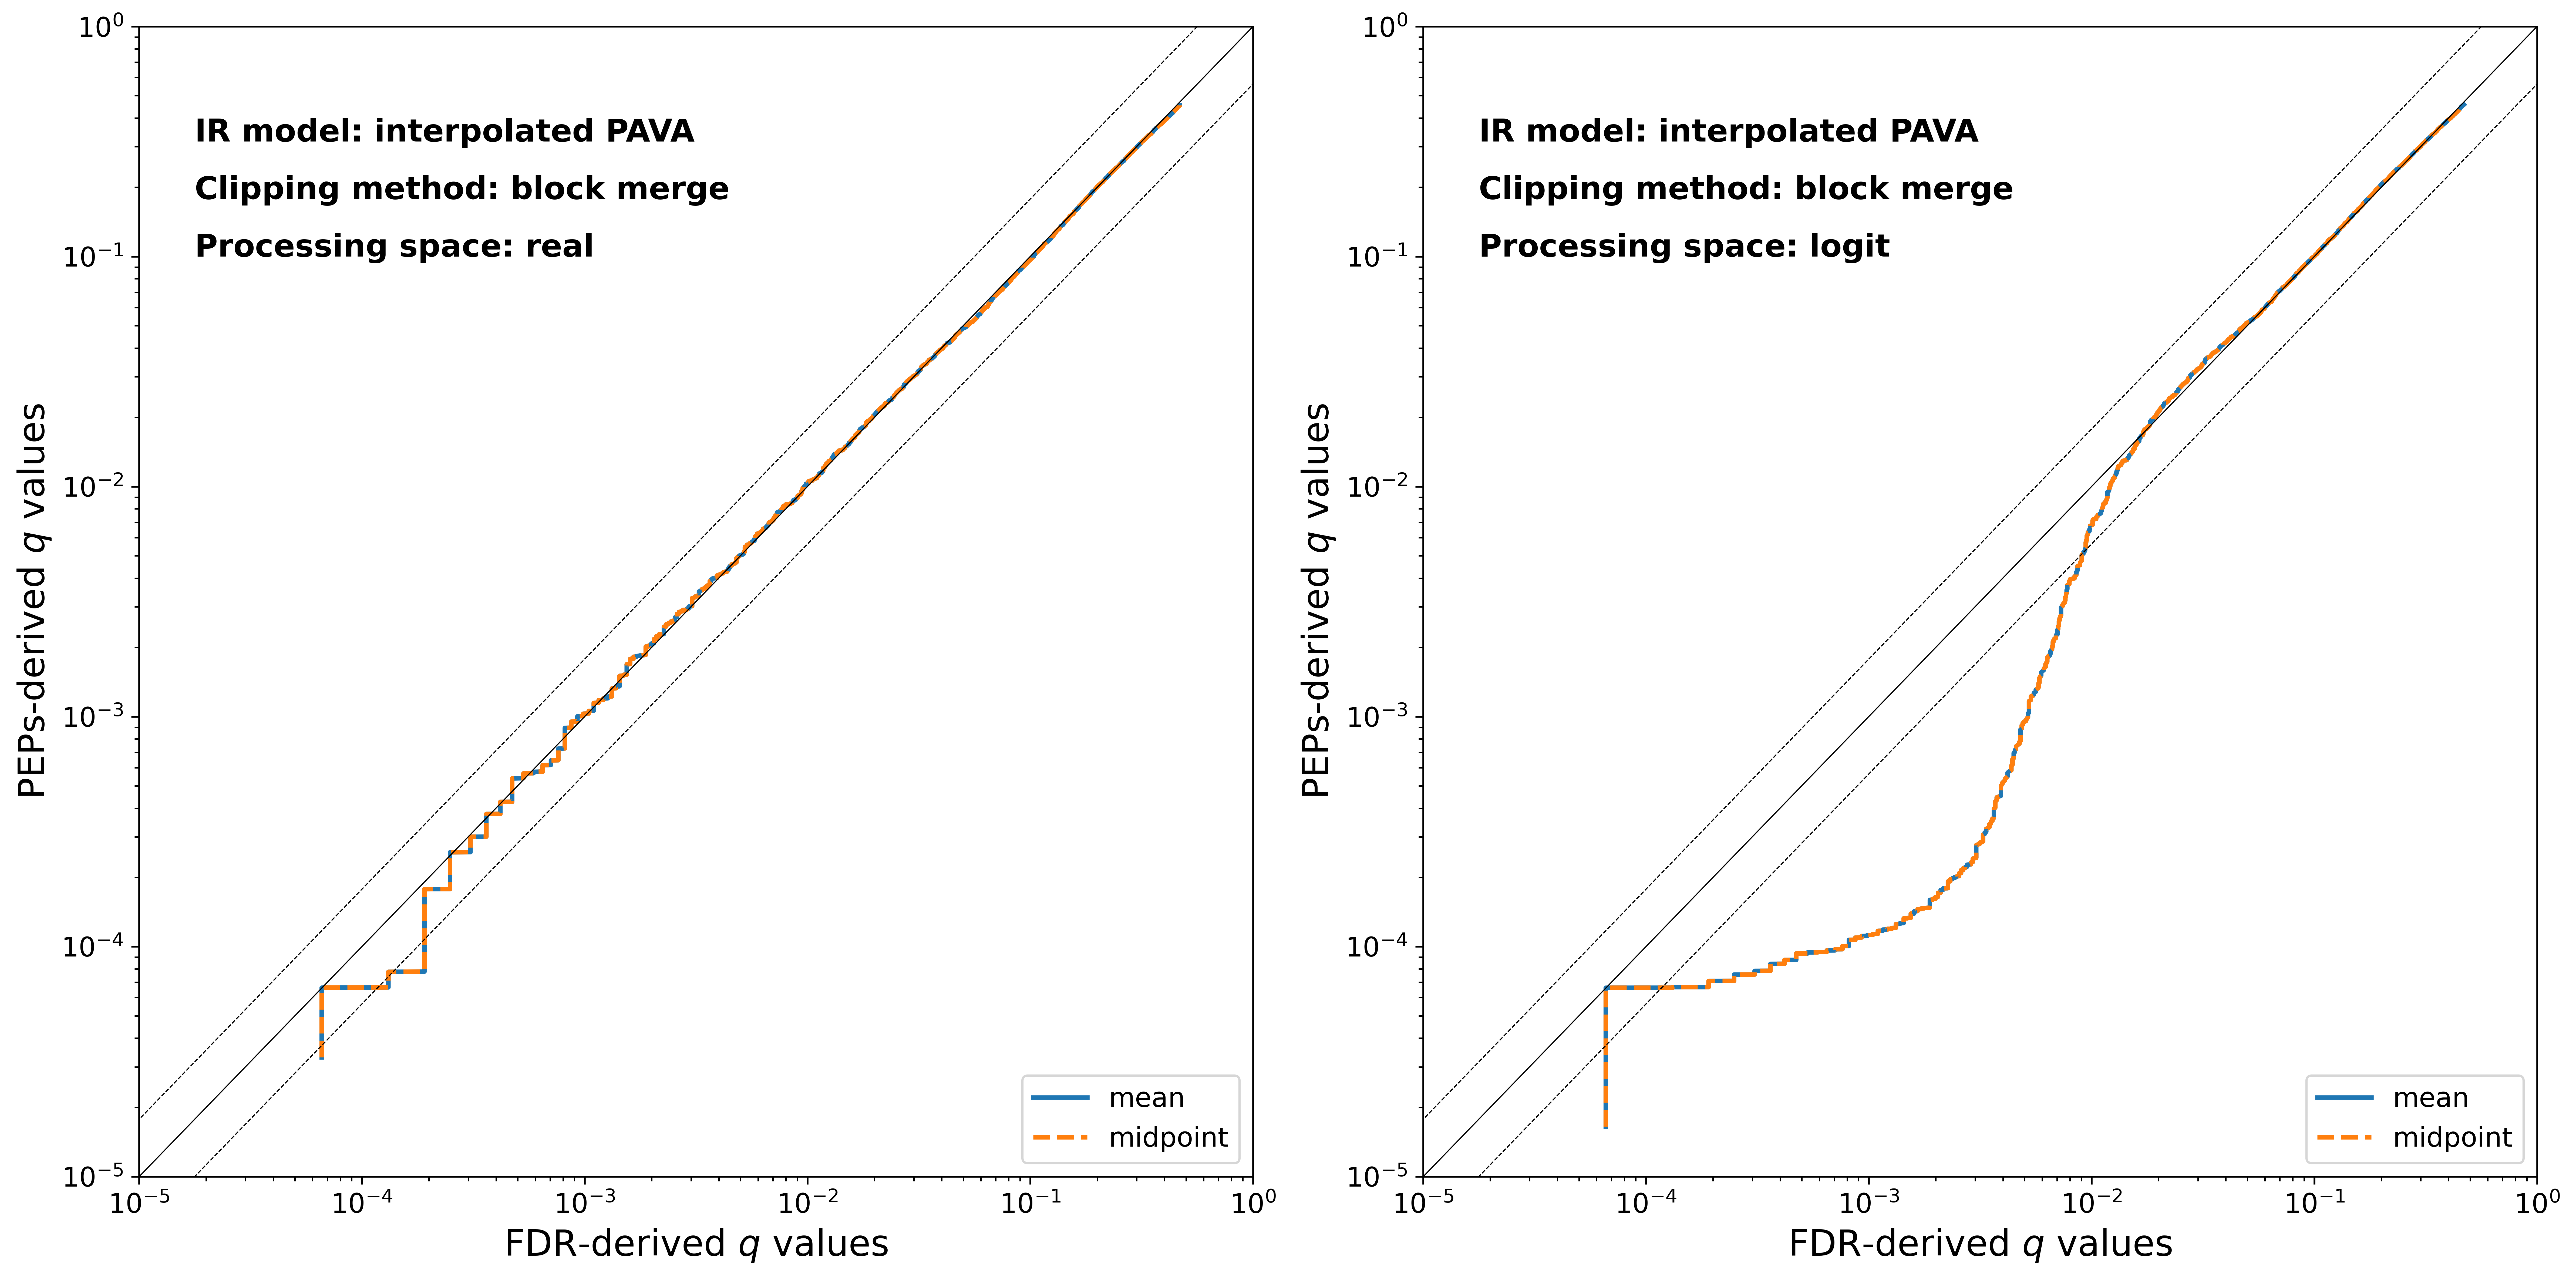

In [21]:
df_mean = pd.read_csv("data/mean.iso0.q_pep.txt", sep="\t")
df_midpoint = pd.read_csv("data/midpoint.iso0.q_pep.txt", sep="\t")
fig, axes = plt.subplots(1, 2, figsize=(16, 8), dpi=600)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
ax = axes[0]
ax.text(0.05, 0.9, "IR model: interpolated PAVA", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "Clipping method: block merge", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: real", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
for i, (col_name, _, _, _) in enumerate([m2]):
    ax.plot(df_mean["q-value"], df_mean[f"q_est_{col_name}"],
            label="mean", linestyle="-", linewidth=2)
    ax.plot(df_midpoint["q-value"], df_midpoint[f"q_est_{col_name}"],
            label="midpoint", linestyle="--", linewidth=2)
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.tick_params(axis="both", labelsize=12)
ax.legend(loc="lower right", fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
ax = axes[1]
ax.text(0.05, 0.9, "IR model: interpolated PAVA", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.85, "Clipping method: block merge", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
ax.text(0.05, 0.8, "Processing space: logit", transform=ax.transAxes,
        fontsize=14, fontweight='bold')
for i, (col_name, _, _, _) in enumerate([m4]):
    ax.plot(df_mean["q-value"], df_mean[f"q_est_{col_name}"],
            label="mean", linestyle="-", linewidth=2)
    ax.plot(df_midpoint["q-value"], df_midpoint[f"q_est_{col_name}"],
            label="midpoint", linestyle="--", linewidth=2)
ax.plot(a, b, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, c, color="k", linewidth=0.5, linestyle="--")
ax.plot(a, a, color="k", linewidth=0.5)
ax.set_xlabel("FDR-derived $q$ values", fontsize=16)
ax.set_ylabel("PEPs-derived $q$ values", fontsize=16)
ax.tick_params(axis="both", labelsize=12)
ax.legend(loc="lower right", fontsize=12)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlim(0.00001, 1)
ax.set_ylim(0.00001, 1)
plt.tight_layout()
plt.savefig("figs/mean_vs_mid.interp_bm.png", bbox_inches="tight")
plt.show()

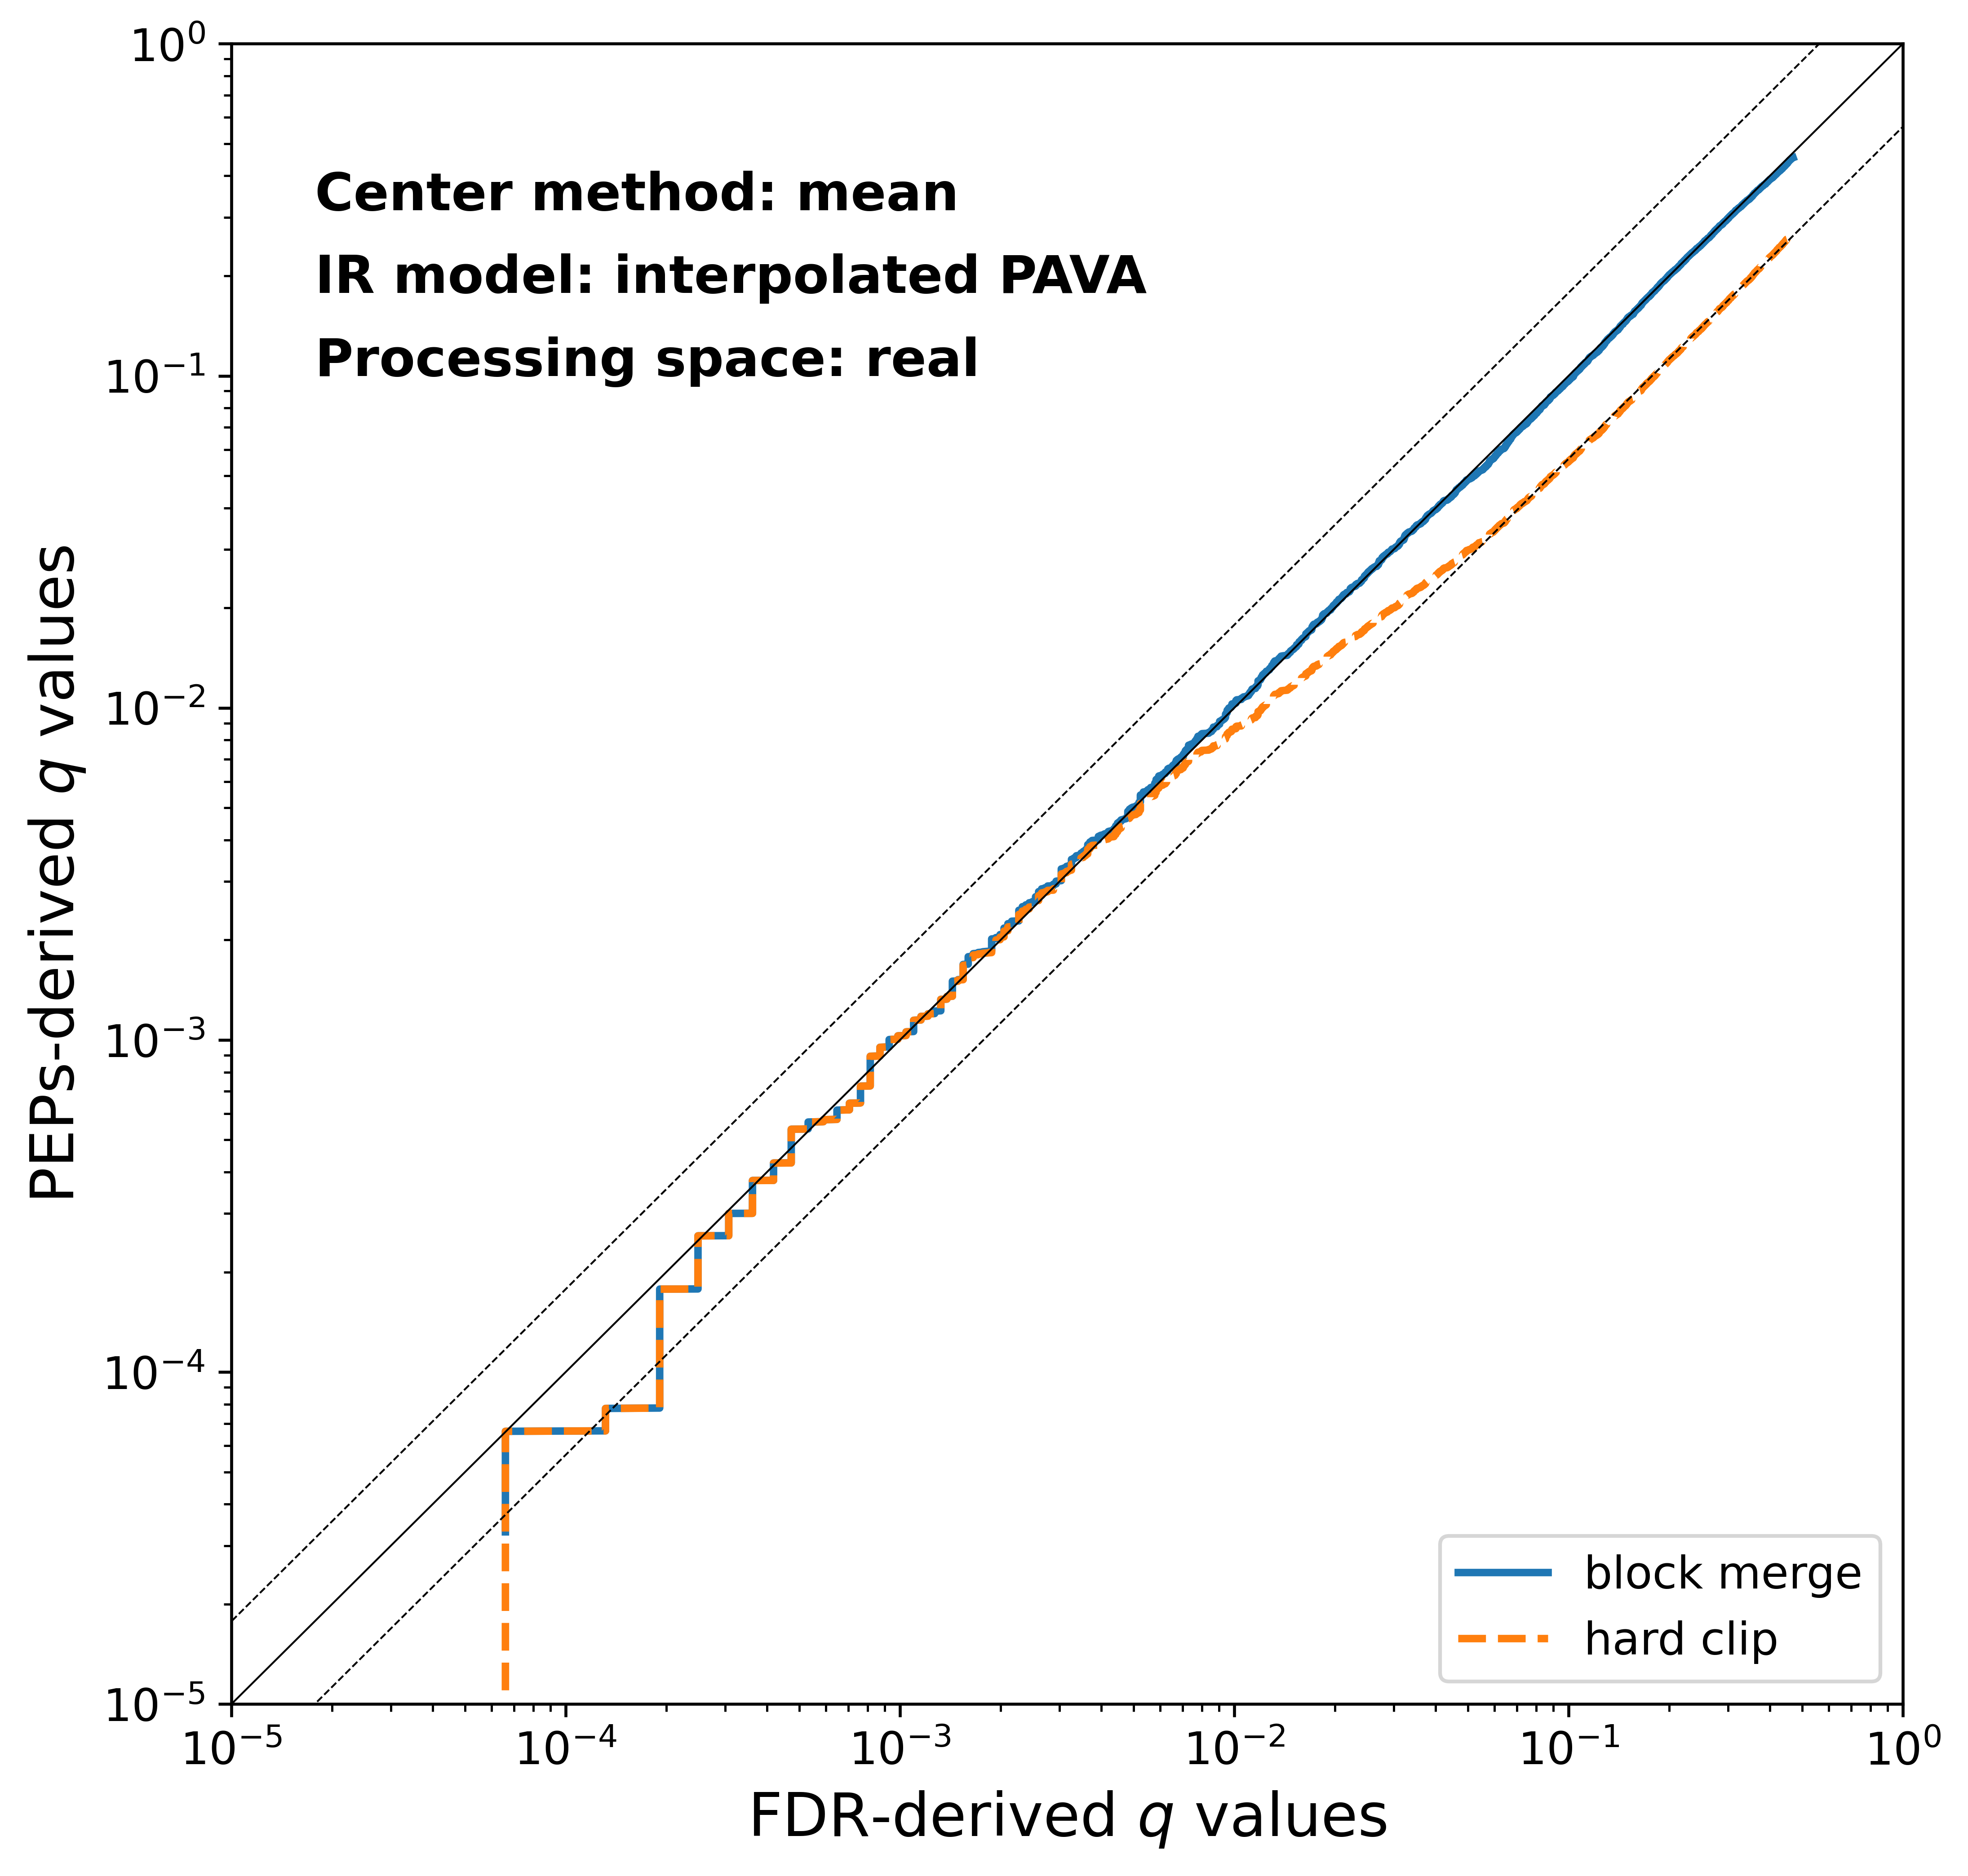

In [11]:
center_methods = ["mean"]
for center_method in center_methods:
    df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
    methods = [m2, m6]
    # methods = [m1, m3, m5, m7]
    plt.figure(figsize=(8, 8), dpi=600)
    plt.text(0.05, 0.9, f"Center method: {center_method}", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.85, "IR model: interpolated PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.8, "Processing space: real", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    # plt.text(0.05, 0.85, "IR model: basic PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    linestyle_map = {"block merge": "-", "hard clip": "--"}
    for i, (col_name, clipping, _, _) in enumerate(methods):
        linestyle = linestyle_map[clipping]
        plt.plot(df["q-value"], df[f"q_est_{col_name}"], label=clipping, linestyle=linestyle, linewidth=2)
    a = np.linspace(0, 1, 100)
    b = a / 10 ** 0.25
    c = a * 10 ** 0.25
    plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, a, c="k", linewidth=0.5)
    plt.xlabel("FDR-derived $q$ values", fontsize=16)
    plt.ylabel("PEPs-derived $q$ values", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    # plt.savefig(f"figs/block_vs_clip.real_mean_interp.png",bbox_inches="tight")
    plt.show()

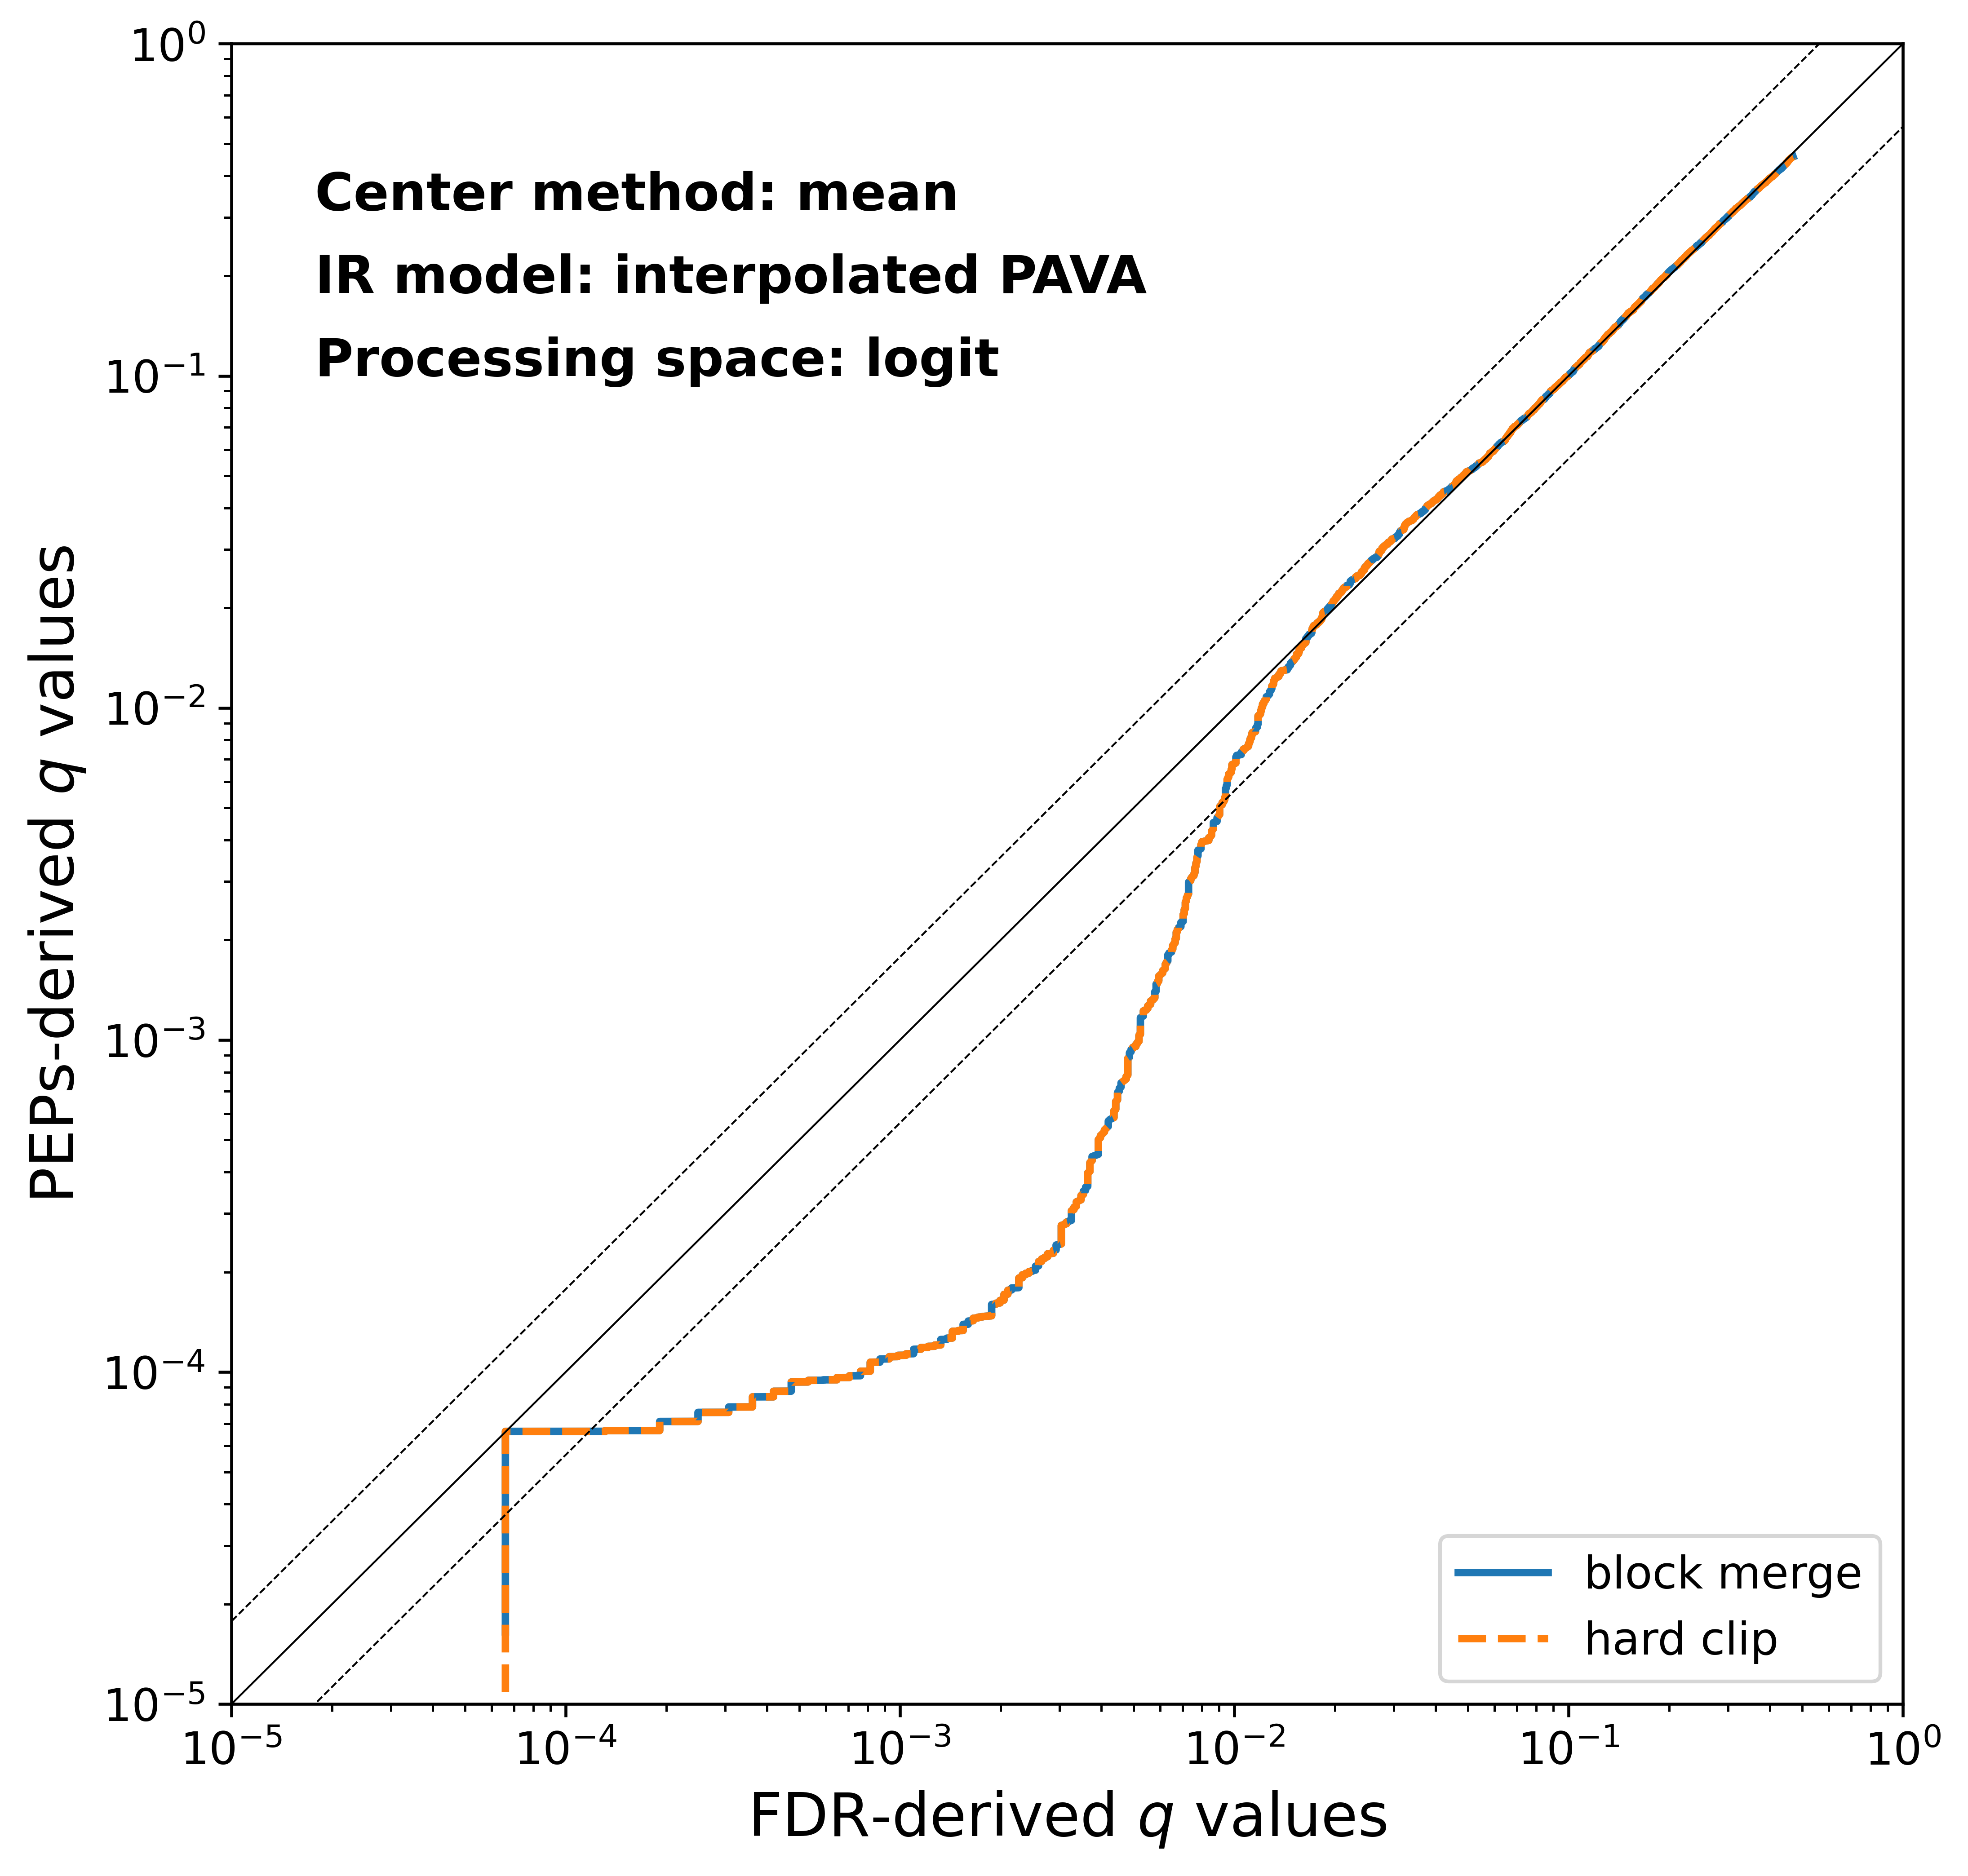

In [5]:
center_methods = ["mean"]
for center_method in center_methods:
    df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
    methods = [m4, m8]
    # methods = [m1, m3, m5, m7]
    plt.figure(figsize=(8, 8), dpi=600)
    plt.text(0.05, 0.9, f"Center method: {center_method}", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.85, "IR model: interpolated PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.8, "Processing space: logit", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    # plt.text(0.05, 0.85, "IR model: basic PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    linestyle_map = {"block merge": "-", "hard clip": "--"}
    for i, (col_name, clipping, _, _) in enumerate(methods):
        linestyle = linestyle_map[clipping]
        plt.plot(df["q-value"], df[f"q_est_{col_name}"], label=clipping, linestyle=linestyle, linewidth=2)
    a = np.linspace(0, 1, 100)
    b = a / 10 ** 0.25
    c = a * 10 ** 0.25
    plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, a, c="k", linewidth=0.5)
    plt.xlabel("FDR-derived $q$ values", fontsize=16)
    plt.ylabel("PEPs-derived $q$ values", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.savefig(f"figs/block_vs_clip.logit_mean_interp.png",bbox_inches="tight")
    plt.show()

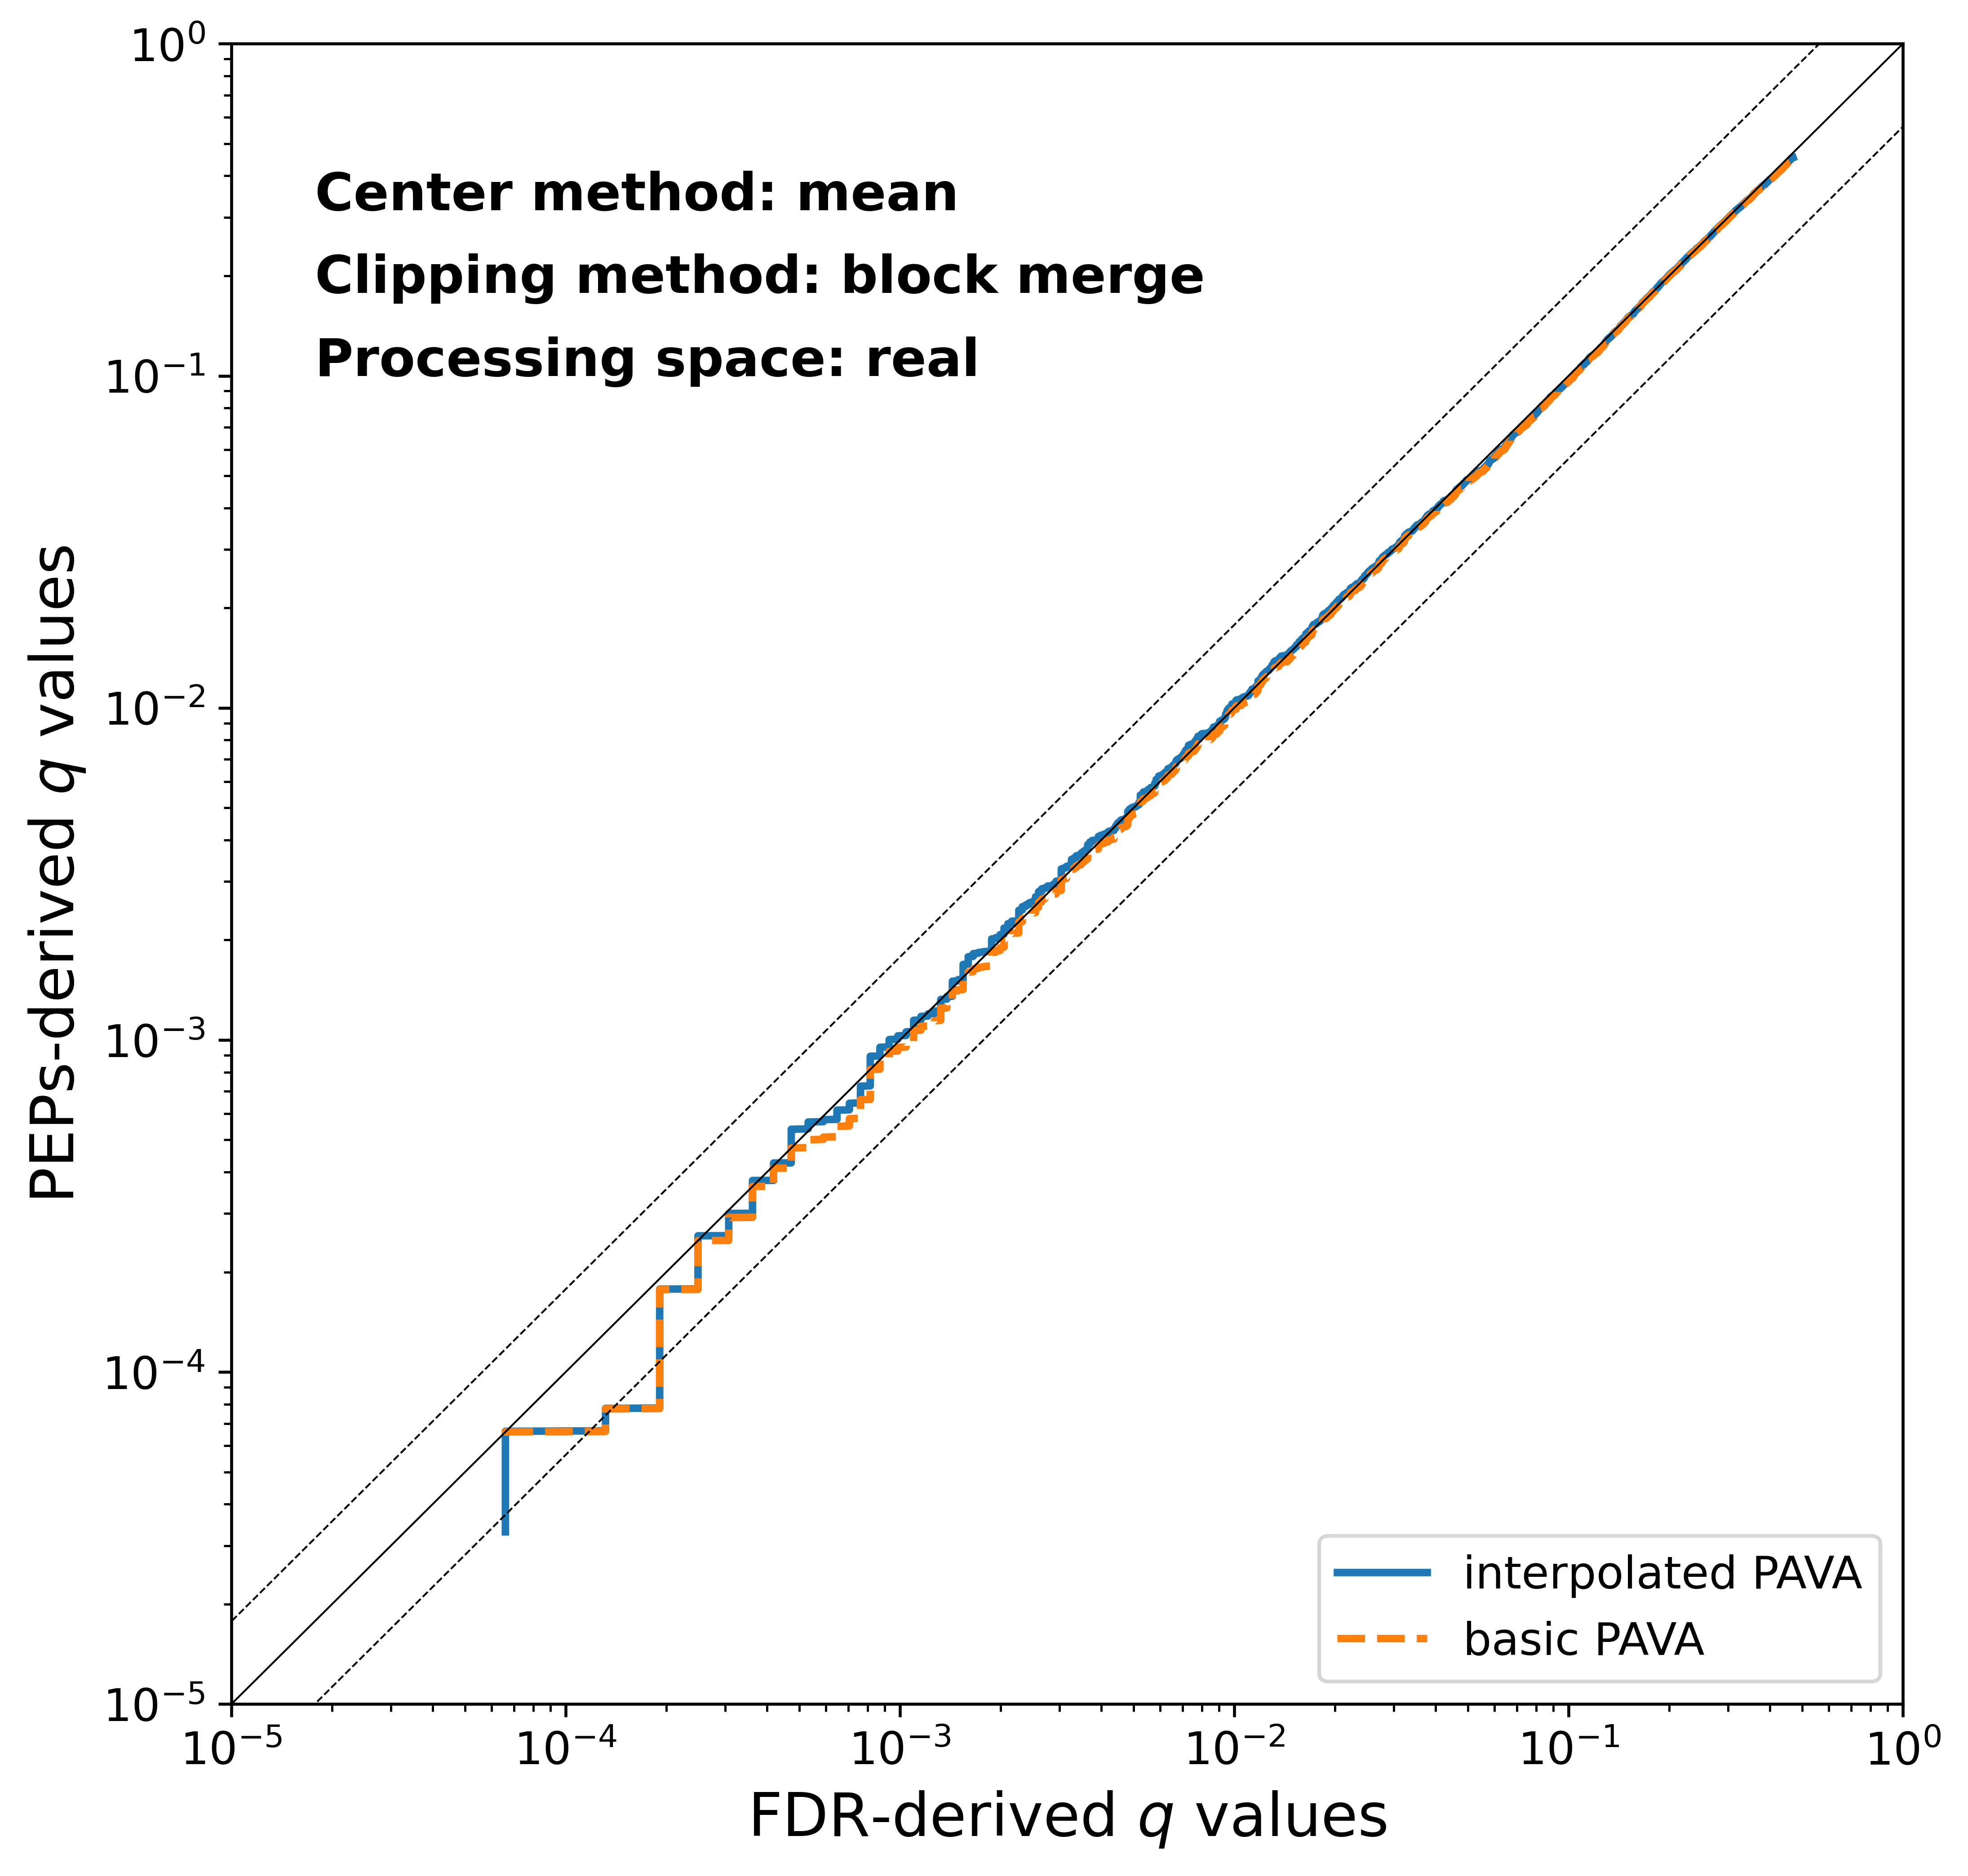

In [6]:
center_methods = ["mean"]
for center_method in center_methods:
    df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
    methods = [m2, m1]
    plt.figure(figsize=(8, 8), dpi=600)
    plt.text(0.05, 0.9, f"Center method: {center_method}", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.85, "Clipping method: block merge", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.8, "Processing space: real", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    linestyle_map = {"interpolated PAVA": "-", "basic PAVA": "--"}
    for i, (col_name, _, _, pava) in enumerate(methods):
        linestyle = linestyle_map[pava]
        plt.plot(df["q-value"], df[f"q_est_{col_name}"], label=pava, linestyle=linestyle, linewidth=2)
    a = np.linspace(0, 1, 100)
    b = a / 10 ** 0.25
    c = a * 10 ** 0.25
    plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, a, c="k", linewidth=0.5)
    plt.xlabel("FDR-derived $q$ values", fontsize=16)
    plt.ylabel("PEPs-derived $q$ values", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.savefig(f"figs/interp_vs_basic.real_mean_bm.png",bbox_inches="tight")
    plt.show()

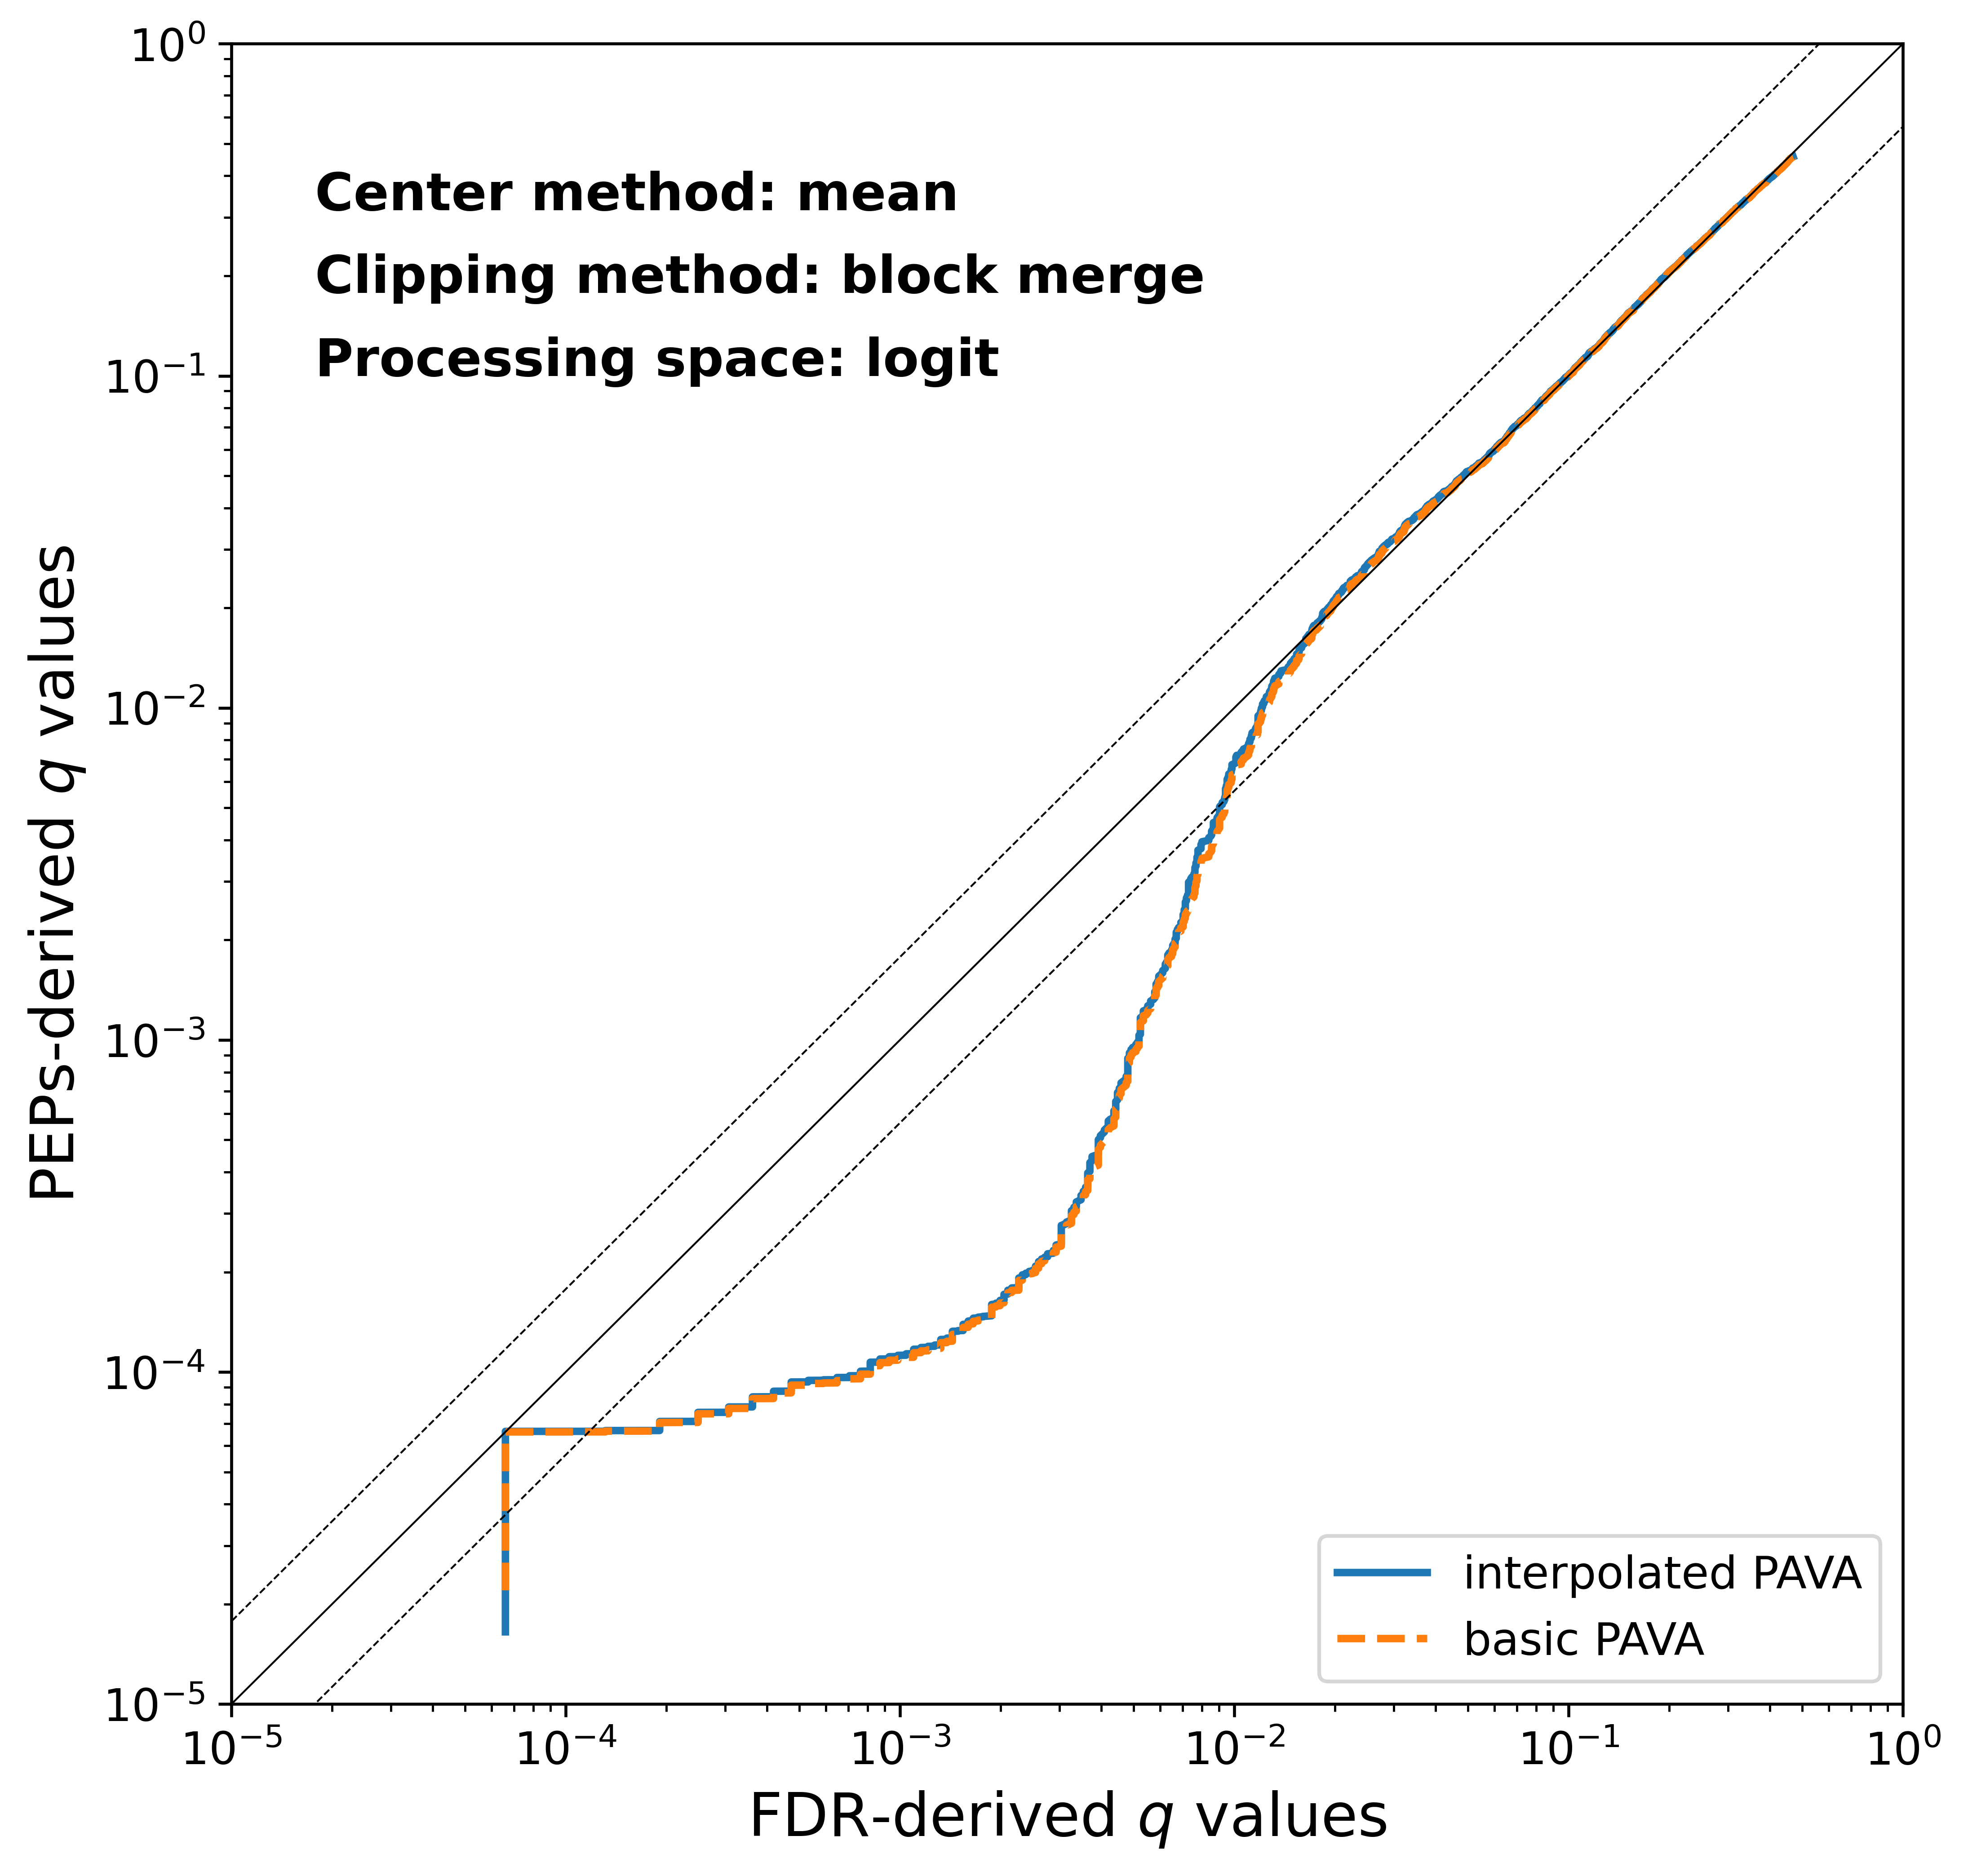

In [7]:
center_methods = ["mean"]
for center_method in center_methods:
    df = pd.read_csv(f"data/{center_method}.iso0.q_pep.txt", sep="\t")
    methods = [m4, m3]
    plt.figure(figsize=(8, 8), dpi=600)
    plt.text(0.05, 0.9, f"Center method: {center_method}", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.85, "Clipping method: block merge", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    plt.text(0.05, 0.8, "Processing space: logit", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
    linestyle_map = {"interpolated PAVA": "-", "basic PAVA": "--"}
    for i, (col_name, _, _, pava) in enumerate(methods):
        linestyle = linestyle_map[pava]
        plt.plot(df["q-value"], df[f"q_est_{col_name}"], label=pava, linestyle=linestyle, linewidth=2)
    a = np.linspace(0, 1, 100)
    b = a / 10 ** 0.25
    c = a * 10 ** 0.25
    plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
    plt.plot(a, a, c="k", linewidth=0.5)
    plt.xlabel("FDR-derived $q$ values", fontsize=16)
    plt.ylabel("PEPs-derived $q$ values", fontsize=16)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(loc='lower right', fontsize=12)
    plt.xscale("log")
    plt.yscale("log")
    plt.xlim(0.00001, 1)
    plt.ylim(0.00001, 1)
    plt.savefig(f"figs/interp_vs_basic.logit_mean_bm.png",bbox_inches="tight")
    plt.show()

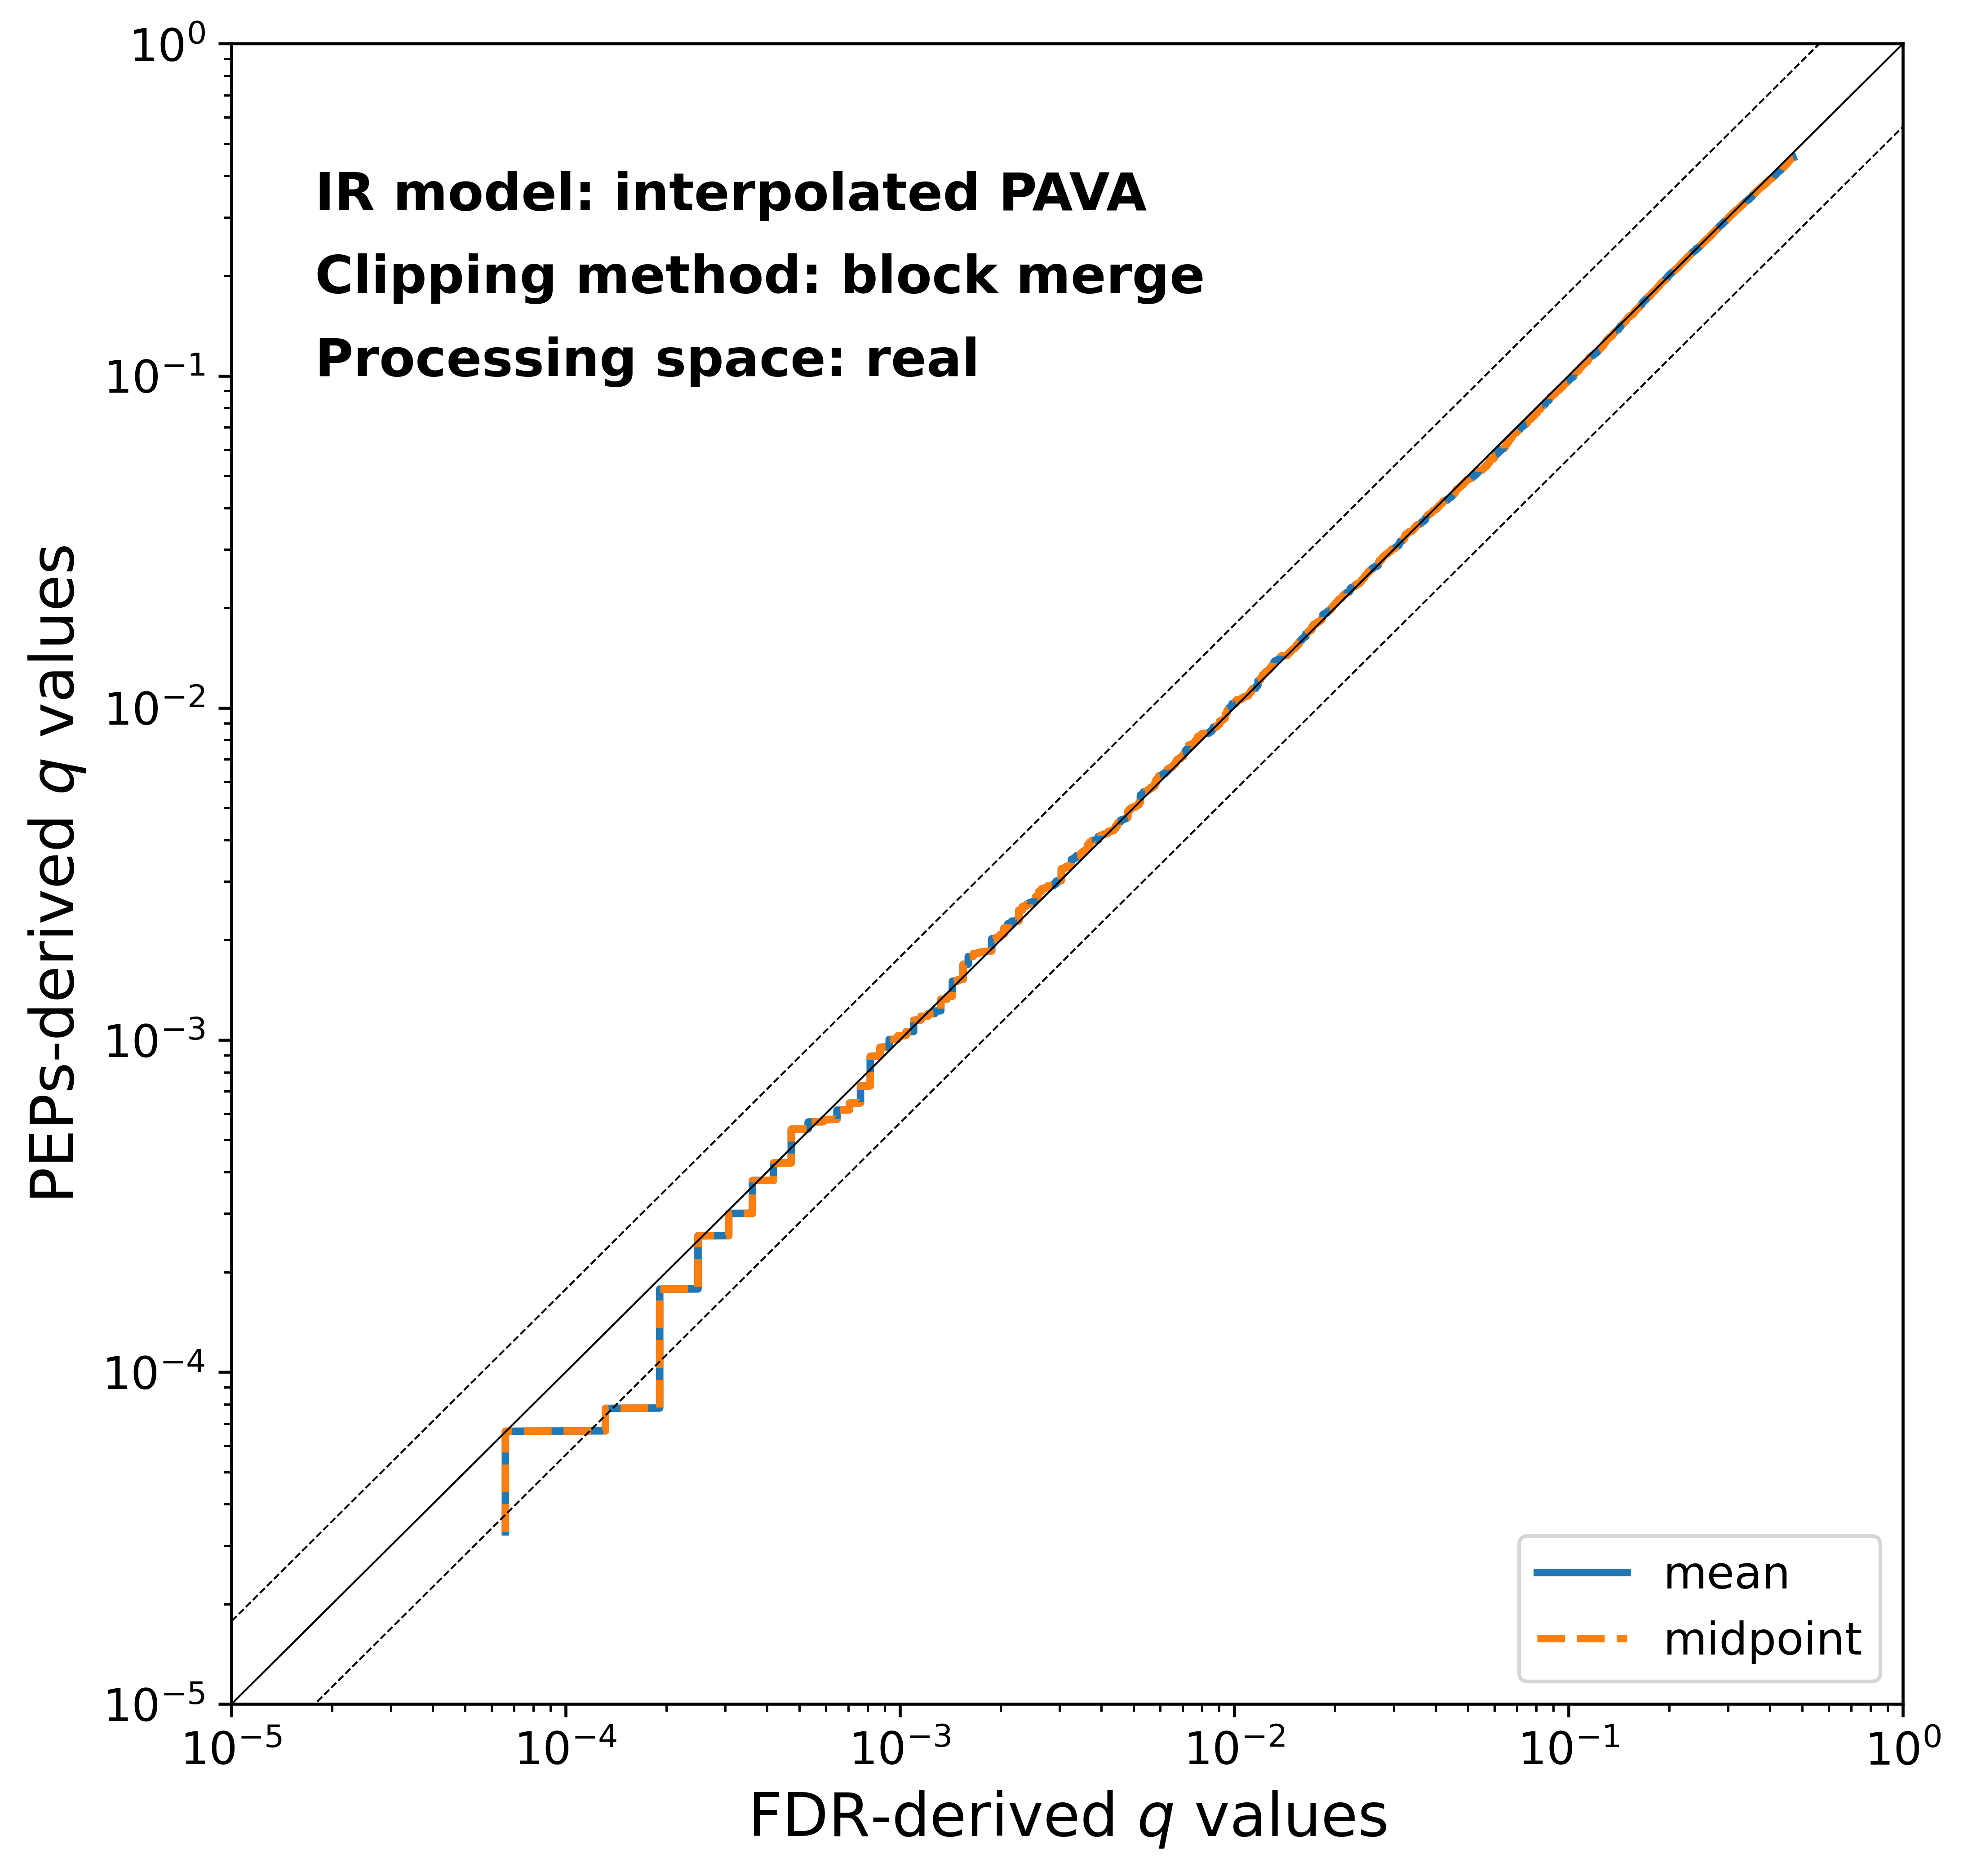

In [8]:
df_mean = pd.read_csv("data/mean.iso0.q_pep.txt", sep="\t")
df_midpoint = pd.read_csv("data/midpoint.iso0.q_pep.txt", sep="\t")
methods = [m2]
plt.figure(figsize=(8, 8), dpi=600)
plt.text(0.05, 0.9, f"IR model: interpolated PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.text(0.05, 0.85, "Clipping method: block merge", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.text(0.05, 0.8, "Processing space: real", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
for i, (col_name, _, _, _) in enumerate(methods):
    plt.plot(df_mean["q-value"], df_mean[f"q_est_{col_name}"], label=f"mean", linestyle="-", linewidth=2)
    plt.plot(df_midpoint["q-value"], df_midpoint[f"q_est_{col_name}"], label=f"midpoint", linestyle="--", linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
plt.savefig(f"figs/mean_vs_mid.real_interp_bm.png",bbox_inches="tight")
plt.show()

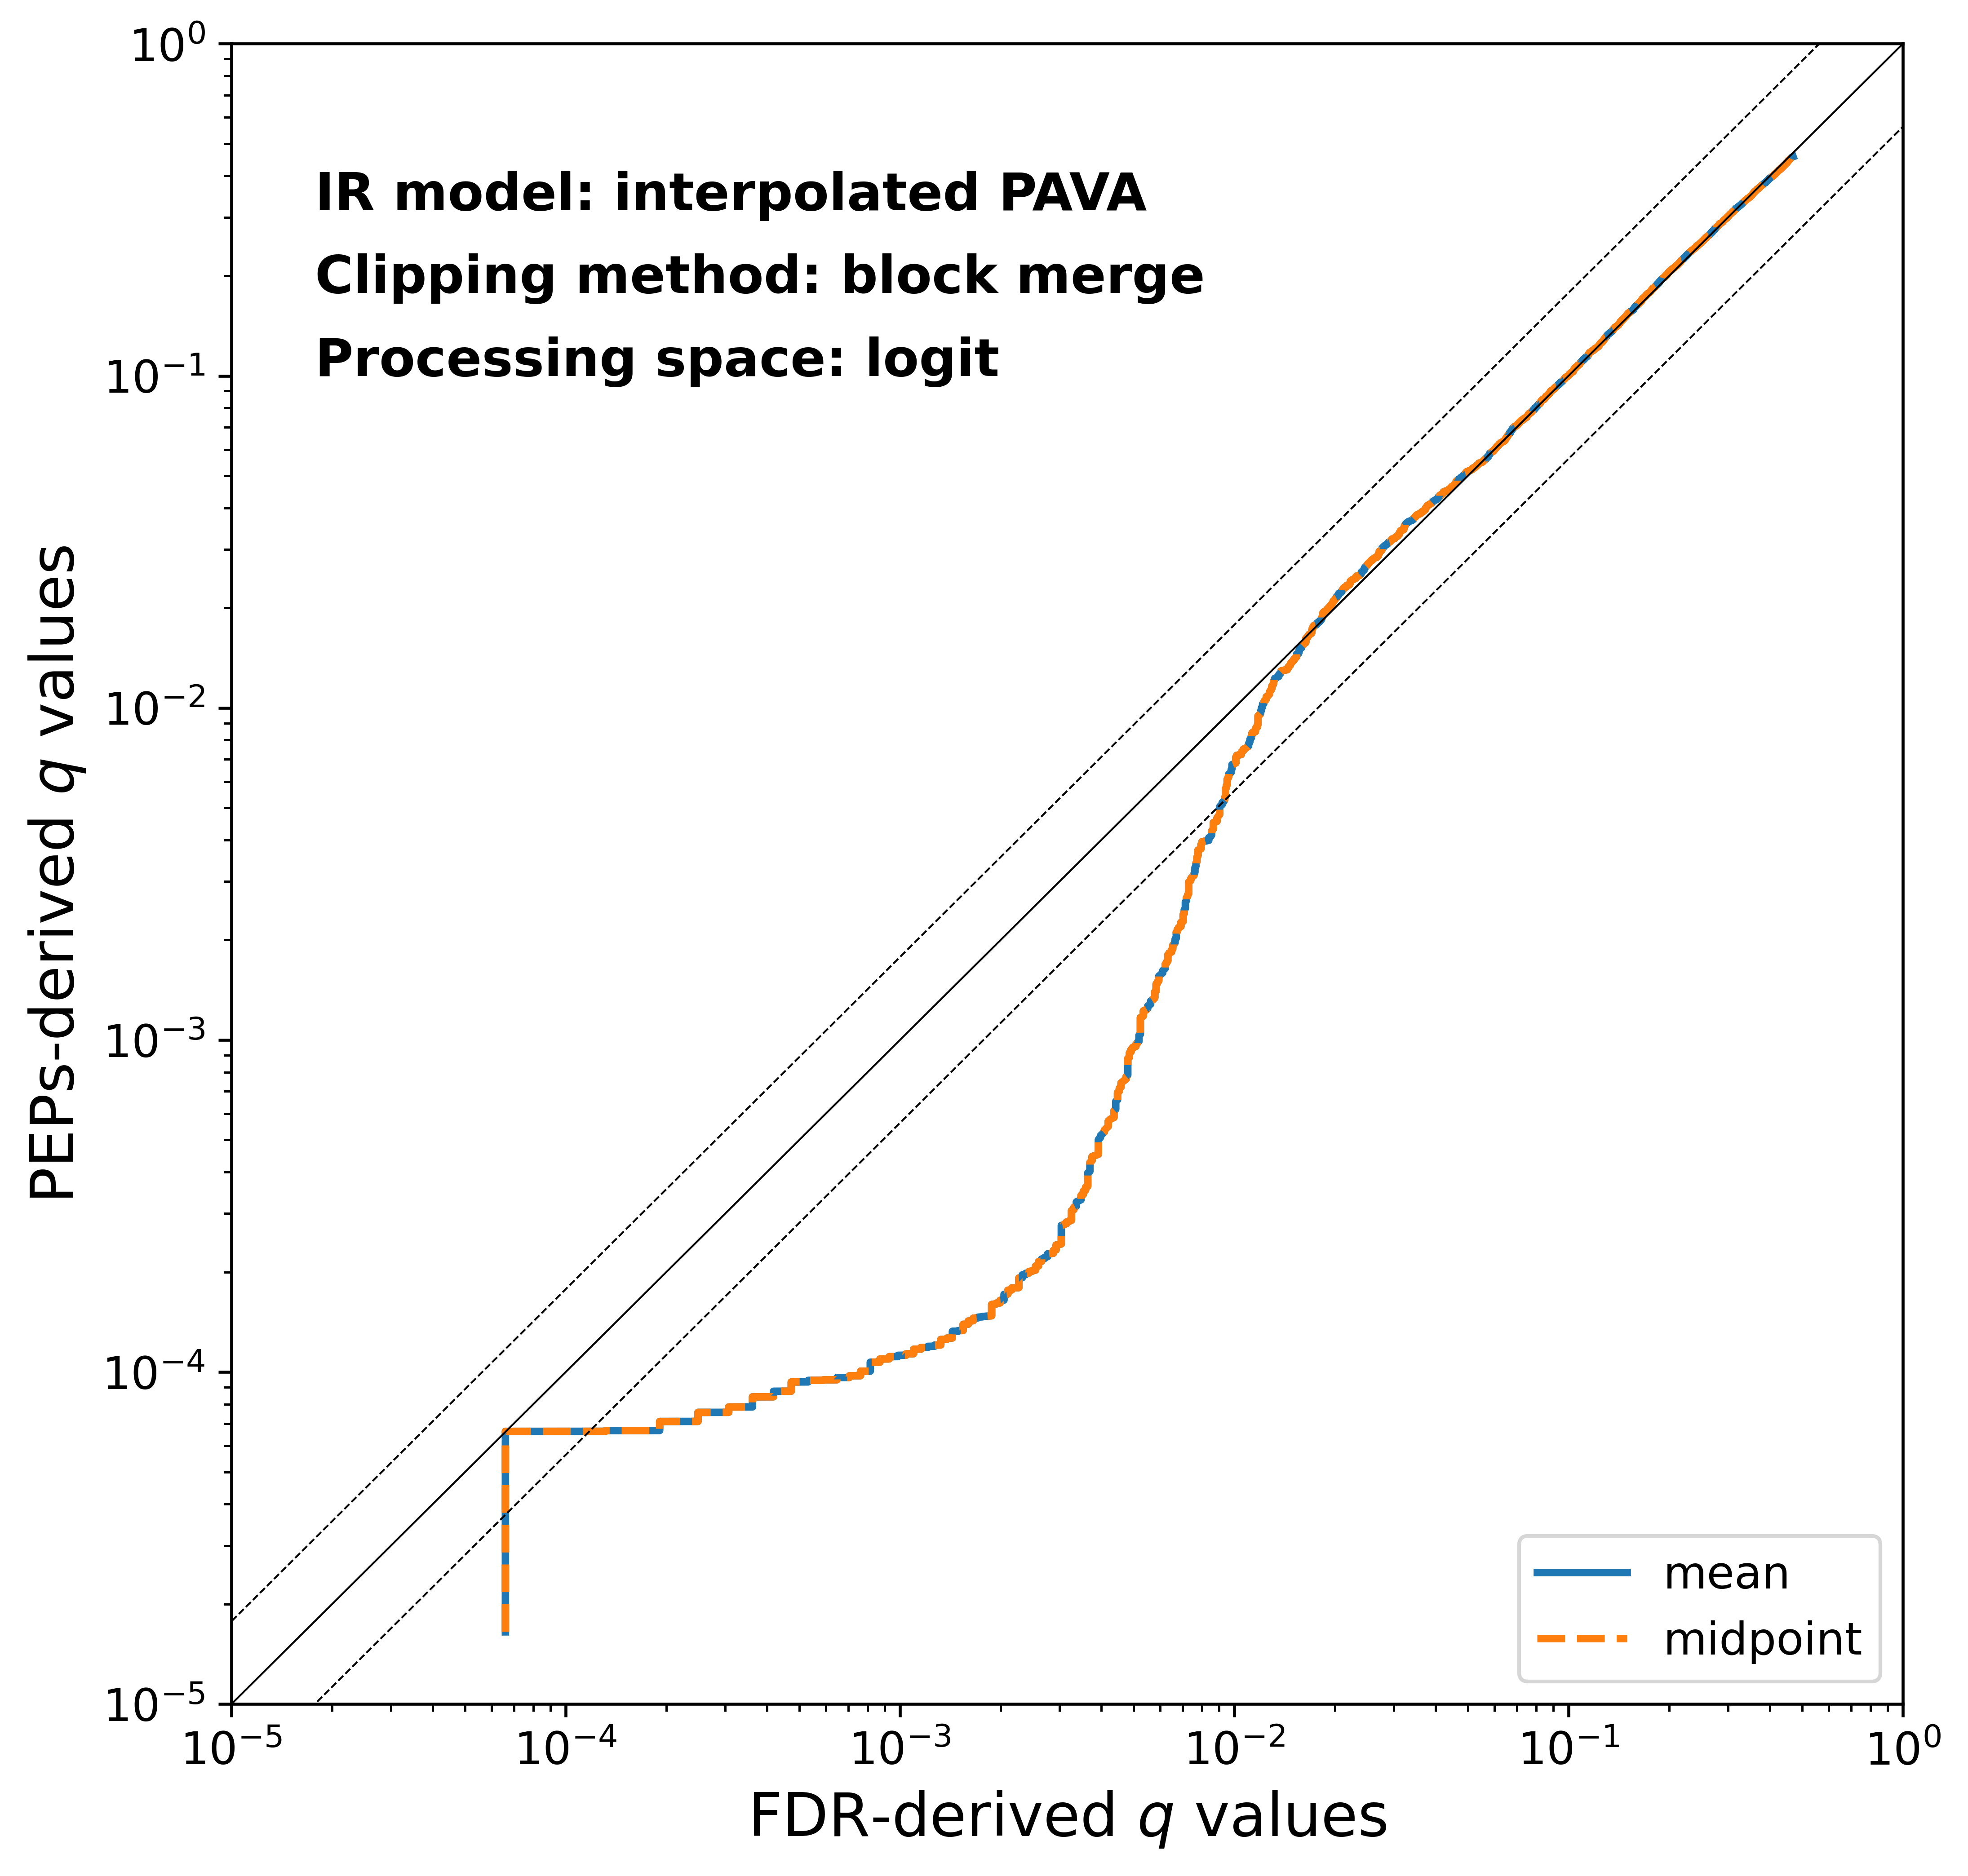

In [9]:
df_mean = pd.read_csv("data/mean.iso0.q_pep.txt", sep="\t")
df_midpoint = pd.read_csv("data/midpoint.iso0.q_pep.txt", sep="\t")
methods = [m4]
plt.figure(figsize=(8, 8), dpi=600)
plt.text(0.05, 0.9, f"IR model: interpolated PAVA", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.text(0.05, 0.85, "Clipping method: block merge", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
plt.text(0.05, 0.8, "Processing space: logit", transform=plt.gca().transAxes, fontsize=14, fontweight='bold')
for i, (col_name, _, _, _) in enumerate(methods):
    plt.plot(df_mean["q-value"], df_mean[f"q_est_{col_name}"], label="mean", linestyle="-", linewidth=2)
    plt.plot(df_midpoint["q-value"], df_midpoint[f"q_est_{col_name}"], label="midpoint", linestyle="--", linewidth=2)
a = np.linspace(0, 1, 100)
b = a / 10 ** 0.25
c = a * 10 ** 0.25
plt.plot(a, b, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, c, c="k", linewidth=0.5, linestyle="--")
plt.plot(a, a, c="k", linewidth=0.5)
plt.xlabel("FDR-derived $q$ values", fontsize=16)
plt.ylabel("PEPs-derived $q$ values", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='lower right', fontsize=12)
plt.xscale("log")
plt.yscale("log")
plt.xlim(0.00001, 1)
plt.ylim(0.00001, 1)
plt.savefig(f"figs/mean_vs_mid.logit_interp_bm.png",bbox_inches="tight")
plt.show()